Ссылка на репозиторий проекта:
https://github.com/andrew-tvorogov/practicum_masterskaya_1

# Рекомендации для инвесторов о целесообразности инвестирования в стартапы на основе данных о стартапах, функционировавших в период с 1970 по 2018 годы.

<b>Заказчик исследования:</b>
- yandex practicum

<b>Источник данных:</b>
- псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) данные о стартапах, функционировавших в период с 1970 по 2018 годы

<b>Содержание данных:</b>
- данные о стартапах;

<b>Порядок проведения исследования:</b>
- загрузить данные;
- изучить данные;
- выполнить предобработку данных;
- полноценный разведочный анализ
    - провести исследовательский анализ;
    - провести корреляционный анализ признаков датасета;
- разработка новых синтетических признаков;
- проверка на мультиколлинеарность;
- отбор финального набора обучающих признаков;
- выбрать лучшую модель (выбор и обучение моделей);
    - создать пайплан обработки признаков;
    - создать пайплайн выбора лучшей модели.
- итоговая оценка качества предсказания лучшей модели;
- анализ важности ее признаков;
- сделать общий вывод на основе готовых моделей (подготовка отчета по исследованию).

<b>Задача:</b>
<p>Разработать решение, которое позволит предсказать какие стартапы закроются.</p>

<b>Цель исследования:</b>
- снижение рисков при инвестировании в стартап;
- получение прибыли;

Данные доступны в файле ``kaggle_startups_train_28062024.csv``

<b>Описание данных:</b>

- ``name`` название стартапа;
- ``category_list`` cписок категорий, к которым относится стартап;
- ``funding_total_usd`` общая сумма финансирования в USD;
- ``status`` татус стартапа (закрыт или действующий);
- ``country_code`` код страны;
- ``state_code`` код штата;
- ``region`` регион;
- ``city`` город;
- ``funding_rounds`` количество раундов финансирования;
- ``founded_at`` дата основания;
- ``first_funding_at`` дата первого раунда финансирования;
- ``last_funding_at`` дата последнего раунда финансирования;
- ``closed_at`` дата закрытия стартапа (если применимо);
- ``lifetime`` время существования стартапа в днях.
</pre>

<b>Дополнительно:</b>

Для участия в соревновании на ресурсе Kaggle доступны дополнительные файлы:
- ``kaggle_startups_train_28062024.csv``
- ``kaggle_startups_sample_submit_28062024.csv``

In [1]:
# установка пакетов
# SHapley Additive exPlanations
#!pip install shap --quiet 

# correlation analyzer library
!pip install phik --quiet

In [2]:
# Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt # для диаграмм
import math # для диаграмм
import numpy as np # для равномерного распределения значений на диаграмме
import seaborn as sns
#import shap # оценка вклада признака
import phik

from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler, 
    OneHotEncoder, 
    OrdinalEncoder)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

from warnings import simplefilter

In [3]:
# Функции

def dataset_info(df):
    '''
    Покажет сводную информацию по датасету
    '''
    cat_columns = df.select_dtypes('object').columns # категориальные
    num_columns = df.select_dtypes('float').columns # количественные
    datetime_columns = df.select_dtypes('datetime64[ns]').columns # датавремя
    print(f'''\n''')
    df.info()
    print(f'''\n''')
    display(df.describe())
    if (len(list(datetime_columns)) > 0):
        display(startups_data[datetime_columns].agg(['min','max']))
        print(f'''\n''')
    print(f'''\n''')
    display(df.head(3))
    print(f'''\n\nЯвных дублей: {df.duplicated().sum()}\n\n''')
    print(f'''Пропущенных значений:\n{df.isna().sum()}\n\n''')

def dataset_tm_info(df):
    '''
    Покажет информацию по datetime колонкам датасета
    '''
    datetime_columns = df.select_dtypes('datetime64[ns]').columns # датавремя
    if (len(list(datetime_columns)) > 0):
        display(startups_data[datetime_columns].agg(['min','max']))
        #print(f'''\n''')
    else:
        print(f'''Нет колонок типа datetime\n''')

# функция для отображения круговой диаграммы распределения количества элементов по категории
def show_category_pie(df, field, title):
    '''
    Отобразит круговую диаграмму распределения количества элементов по категории
    '''
    df[field]\
    .value_counts().plot(kind='pie', title = title + ', %', autopct='%1.0f%%', figsize=(5,5))
    plt.ylabel('')
    plt.show()

# функция для отображения количественных признаков в виде графиков - гистограммы и ящика с усами
def show_numeric_bplt_hist(df, variable, first_label, second_label, bins):
    '''
    Отобразит количественные признаки в виде графиков - гистограммы и ящика с усами
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(df[variable], bins=bins)
    ax1.set_title('Гистограмма')
    ax1.set_xlabel(first_label)
    ax1.set_ylabel(second_label)    
    ax1.grid(True)    
    
    ax2.boxplot(df[variable], vert=False)
    ax2.set_title('Ящик с усами')
    ax2.set_xlabel(first_label)
    ax2.set_ylabel(second_label)
    ax2.grid(True)
    ax2.set_yticks([])

    plt.show()
    
def show_two_barh(df_left, df_right, field, y_label, left_title, right_title):
    '''
    Отобразит две столбчатые диаграммы(горизонтальные) распределения количества элементов по категории для двух датасетов
    '''
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

    df_left[field].value_counts(normalize=True).sort_values().plot.barh(alpha=0.5, color=colors[0], label='', ax=ax1)
    ax1.set_title(left_title)
    ax1.set_ylabel(y_label)    
    df_right[field].value_counts(normalize=True).sort_values().plot.barh(alpha=0.5, color=colors[1], label='', ax=ax2)    
    ax2.set_title(right_title)
    plt.show()
        
def show_two_countplots(df_left, df_right, field, y_label, x_label, left_title, right_title, y_lim=(0, 100), rotation=0, sort_field=None, prefix=''):
    '''
    Отобразит две countplot диаграммы распределения количества элементов по категории для двух датасетов
    '''
    #if (sort_field):
    #    df_left['day_index'] = df_left[sort_field] # индекс для сортировки
    #    df_left_copy = df_left.sort_values(by=f'{prefix}_{sort_field}')[field].copy()
    #    display(df_left_copy)     
    
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)
    
    left = sns.countplot(df_left[field], color=colors[0], ax=axes[0], alpha=0.5)
    left.set(xlabel=x_label, ylabel=y_label, title=left_title, ylim=y_lim)
    left.set_xticklabels(left.get_xticklabels(), rotation=rotation)
    
    right = sns.countplot(df_right[field], color=colors[1], ax=axes[1], alpha=0.5)
    right.set(xlabel=x_label, ylabel=y_label, title=right_title, ylim=y_lim)
    right.set_xticklabels(right.get_xticklabels(), rotation=rotation)
    
    plt.show()    

def count_lifetime(el):
    '''
    Посчитает количество дней существования стартапа
    '''
    if el['status'] == 'operating':
        return (pd.to_datetime('2018-01-01') - el["founded_at"]).days # самая "правая" дата по условию 2018-01-01
    else:
        return (el['closed_at'] - el["founded_at"]).days

def funding_per_round(value):
    '''
    Подсчитает финансирование за 1 раунд
    '''
    if value['funding_total_usd'] > 0:
        return round(value['funding_total_usd'] / value['funding_rounds'])
    else:
        return 0

def fill_nan_funding(value, funding_avg):
    '''
    Заполнит пропуски в 'funding_total_usd',
    используя величину среднего финансирования за раунд и количество раундов
    '''
    if value['funding_total_usd'] > 0:        
        return value['funding_total_usd']
    else:
        return value['funding_rounds'] * funding_avg

def fill_funding_total_usd(df):
    '''
    Заполнит пропуски в 'funding_total_usd' для датафрейма df
    '''
    df['funding_per_round'] = df.apply(lambda x: funding_per_round(x), axis=1)
    funding_median = df.query('funding_per_round > 0')['funding_per_round'].median()    
    df['funding_total_usd'] = df.apply(lambda x: fill_nan_funding(x, funding_median), axis=1)
    df = df.drop(columns=['funding_per_round'])
    return df    

In [4]:
# инициализация глобальных переменных
RANDOM_STATE = 42 # Deep Thought number
TEST_SIZE = 0.25 # размер выборки

In [5]:
# настройки
pd.options.display.max_columns = None # необходимо чтобы head отобразил все колонки
plt.rcParams['figure.figsize'] = [15, 3] # размеры графика по умолчанию
sns.set(rc={'figure.figsize':(15, 10)}) # размеры графика seaborn по умолчанию
pd.set_option('display.float_format', '{:.2f}'.format) # отобразит в колонках округленные данные до 6-ти знаков

simplefilter(action='ignore', category=FutureWarning) # уберёт предупреждение "Set `keepdims`

# цвета для диаграмм
colors = ['gray','#3672b4','#ac0936']

# Загрузка и изучение данных

## Загрузка

In [6]:
# загрузка данных в датасеты
try:
    startups_data = pd.read_csv('./datasets/kaggle_startups_train_28062024.csv') # рабочий датасет
    startups_test = pd.read_csv('./datasets/kaggle_startups_test_28062024.csv') # датасет test для соревнования
    startups_submit = pd.read_csv('./datasets/kaggle_startups_sample_submit_28062024.csv')  # пример результата
except:
    print("Ошибка. Данные не загружены")

### Сводная информация датасет - ``startups_data``

In [7]:
dataset_info(startups_data)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB




,funding_total_usd,funding_rounds
count,42447.00,52516.00
mean,18247480.66,1.74
std,187117301.32,1.37
min,1.00,1.00
25%,336027.50,1.00
50%,2000000.00,1.00
75%,10000000.00,2.00
max,30079503000.00,19.00


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN




Явных дублей: 0


Пропущенных значений:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64




<span style="color: darkgreen">Явных дублей нет. </span><br><span style="color: #f85c00">Есть пропущенные значения, которые необходимо заполнить, используя разные стратегии.<br>Типы данных выглядят нормально за исключением трёх атрибутов - **founded_at**, **first_funding_at** и **last_funding_at**, которые необходимо привести к типу **datetime64[ns]**.</span>

### Сводная информация датасет - ``startups_test``

In [8]:
dataset_info(startups_test)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB




,funding_total_usd,funding_rounds,lifetime
count,10547.00,13125.00,13125.00
mean,16549102.70,1.71,3097.61
std,92172825.63,1.32,2128.36
min,1.00,1.00,52.00
25%,320000.00,1.00,1726.00
50%,2000000.00,1.00,2526.00
75%,10000000.00,2.00,3866.00
max,4715000000.00,15.00,17167.00


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295




Явных дублей: 0


Пропущенных значений:
name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64




<span style="color: darkgreen">Явных дублей нет. </span><br><span style="color: #f85c00">Есть пропущенные значения, которые необходимо заполнить, используя разные стратегии.<br>Типы данных выглядят нормально за исключением двух атрибутов - **first_funding_at** и **last_funding_at**, которые необходимо привести к типу **datetime64[ns]**.</span>

### Сводная информация датасет - ``startups_submit``

In [9]:
dataset_info(startups_submit)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB




,name,status
count,13125,13125
unique,13125,2
top,Triosyn,operating
freq,1,6635


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed




Явных дублей: 0


Пропущенных значений:
name      0
status    0
dtype: int64




<span style="color: darkgreen">Явных дублей нет. Пропущенных значений нет. Типы данных - корректны. </span>

**Вывод:**
- Во всех трёх датасетах нет явных дублей;
- Датасет startups_submit - пример структуры результата для соревнований. В проекте не будет использован. Явных дублей, пропущенных значений в нём нет. Данные корректны. Структура понятна.
- Состав и количество колонок в ``startups_data`` и ``startups_test`` - отличаются.
    - ``startups_test`` содержит колонку **life_time**, которой нет в ``startups_data``
    - ``startups_data`` содержит колонку **founded_at** и **closed_at**, которых нет в ``startups_test``
- Поскольку результат для соревнования должен быть получен при использовании ``startups_test``, необходимо предварительно привести состав колонок ``startups_data`` к ``startups_test``. Колонка **life_time** может быть заполнена из колонок **founded_at** и **closed_at** простым подсчётом дней.

# Предобработка данных

In [10]:
startups_test_source = startups_test # для выгрузки предсказаний соревнования

## Приведение типов данных колонок к **datetime64**

### ``startups_data`` - колонки "founded_at","first_funding_at","last_funding_at","closed_at"

In [11]:
date_cols = ["founded_at","first_funding_at","last_funding_at","closed_at"]
startups_data[date_cols] = startups_data[date_cols].astype("datetime64[ns]")

In [12]:
startups_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

### ``startups_test`` - колонки "first_funding_at","last_funding_at"

In [13]:
date_cols = ["first_funding_at","last_funding_at"]
startups_test[date_cols] = startups_test[date_cols].astype("datetime64[ns]")

In [14]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


<span style="color: darkgreen">Типы данных в столбцах датасетов - корректны.</span>

## Анализ данных колонок типа **datetime64**

### Датасет -``startups_data``

In [15]:
dataset_tm_info(startups_data)

,founded_at,first_funding_at,last_funding_at,closed_at
min,1970-02-05,1977-05-15,1977-05-15,1983-10-06
max,2016-04-02,2015-12-05,2015-12-07,2017-10-21


### Датасет - ``startups_test``

In [16]:
dataset_tm_info(startups_test)

,first_funding_at,last_funding_at
min,1977-05-15,1977-05-15
max,2015-12-05,2015-12-07


<span style="color: darkgreen">Минимальная и максимальная даты в обоих датасетах находятся в корректном диапазоне. Выбросов и странных значений - нет.</span>

## Приведение набора столбцов в датасетах к набору столбцов ``startups_test``

### Добавление столбца **lifetime** к датасету ``startups_data``

Для добавления столбца используется предварительно определённая функция *count_lifetime*.

Количество дней подсчитывается исходя из даты основания **founded_at** и даты закрытия **closed_at**. Если дата закрытия не определена, то берётся дата ``2018-01-01`` (самая поздняя дата в датасете).

Проверка, что количество записей в колонке **status**, имеющих статус ``closed``, соответствует количеству записей в колонке **closed_at** и не ``NuT``.

In [17]:
len(startups_data[startups_data['closed_at'].notna()])

4917

In [18]:
len(startups_data[startups_data['status'] == 'closed'])

4917

Количество совпадает и равно 4917 - итого 4917 стартапов были закрыты и есть их дата закрытия.

In [19]:
startups_data['lifetime'] = startups_data.apply(count_lifetime, axis=1) # функция добавит новый столбец

In [20]:
startups_data.head(1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2998


<span style="color: darkgreen">Столбец **lifetime** добавлен.</span>

In [21]:
# разница, выраженная в днях
#startups_data["lifetime"] = \
#(pd.to_datetime('2018-01-01') - startups_data["founded_at"]).dt.days
#startups_data

### Удаление из датасета ``startups_data`` колонок, которых нет в датасете ``startups_test`` - **founded_at** и **closed_at**

In [22]:
startups_data = startups_data.drop(columns=['founded_at', 'closed_at'])

In [23]:
startups_data.head(1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998


In [24]:
startups_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  lifetime           52516 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 4.8+ MB


In [25]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


<span style="color: darkgreen">**Набор столбцов в датасетах - корректен.** Целевой признак - **status** есть только в ``startups_data``</span>

### Замена пропуска в колонке **name** на 'unknown' в датасете ``startups_data``

In [26]:
startups_data['name'].fillna('unknown', inplace=True)

In [27]:
startups_data['name'].isna().sum()

0

<span style="color: darkgreen">Пропуск в столбце **name** заполнен.</span>

### Замена пропусков в колонке **category_list** на 'unknown' в датасетах ``startups_data`` и ``startups_test``

Заполнение пропусков в колонке **category_list** (категория) на 'unknown'. Это необходимо, поскольку из датафрейма ``startups_test`` строки точно нельзя удалить, это скажется на итоговом наборе строк в таблице для соревнования.

In [28]:
startups_data['category_list'].fillna('unknown', inplace=True)
startups_test['category_list'].fillna('unknown', inplace=True)

In [29]:
startups_data['category_list'].isna().sum()

0

In [30]:
startups_test['category_list'].isna().sum()

0

<span style="color: darkgreen">Пропуски в столбце **category_list** заполнены.</span>

### Заполнение пропусков в поле **funding_total_usd**

Для заполнения пропусков используем медианное значение финансирование за раунд финансирования.

In [31]:
startups_data = fill_funding_total_usd(startups_data)

In [32]:
startups_test = fill_funding_total_usd(startups_test)

### Замена пропусков в колонках, связаных с регионом - **country_code, state_code, region, city** на 'unknown' в датасетах ``startups_data`` и ``startups_test``

In [33]:
region_columns = ['country_code','state_code','region','city']
for a in region_columns:
    startups_data[a].fillna('unknown', inplace=True)
    startups_test[a].fillna('unknown', inplace=True)

In [34]:
startups_data.isna().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [35]:
startups_test.isna().sum()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

**Вывод:**
- В обоих датасетах **отсутствуют пропуски.

### Корректировка категории у записей с категорией "Social + Mobile + Local"

Ниже по коду при выделении уникальных категорий из составных - обнаружена категория "Social + Mobile + Local". Вероятно истииное значение должно быть "Social|Mobile|Local"

In [36]:
startups_data[startups_data['category_list'] == 'Social + Mobile + Local']

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
35481,Jodel,Social + Mobile + Local,1300000.00,closed,unknown,unknown,unknown,unknown,1,2014-08-01,2014-08-01,649
43832,DormChat,Social + Mobile + Local,1300000.00,operating,USA,NY,New York City,New York,1,2014-10-23,2014-10-23,1741


In [37]:
startups_test[startups_test['category_list'] == 'Social + Mobile + Local']

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [38]:
startups_data.loc[startups_data['category_list'] == 'Social + Mobile + Local', 'category_list'] = 'Social|Mobile|Local'

In [39]:
len(startups_data[startups_data['category_list'] == 'Social + Mobile + Local'])

0

<span style="color: darkgreen">Составная категория 'Social|Mobile|Local' заполена корректно.</span>

# EDA

## Разведочный анализ категориальных признаков

In [40]:
def category_check(df, cats):
    for cat in cats:        
        print(f'''Столбец: {cat}\nУникальных значений: {df[cat].unique().shape[0]}''')        
        #cat_df = pd.DataFrame(df[cat].unique(), columns=[cat]).sort_values(by=cat,ascending=True)
        #display(cat_df)        
        cat_df_count = pd.DataFrame(df[cat].value_counts().sort_values(ascending=False))
        cat_df_count = cat_df_count.rename(columns={cat: "Количество стартапов"})
        display(cat_df_count)

In [41]:
fields_to_check = ['name','category_list','country_code','state_code','region','city']

### Базовый анализ категориальных признаков для ``startups_data``

In [42]:
category_check(startups_data, fields_to_check)

Столбец: name
Уникальных значений: 52516


,Количество стартапов
RFI Global Services,1
Nanotech Partners,1
Health Benefits Direct,1
AreaMetrics,1
Birbl,1
...,...
Exablox,1
Weizoom,1
Dental Kidz,1
IdentityForge,1


Столбец: category_list
Уникальных значений: 22106


,Количество стартапов
Software,3207
Biotechnology,2905
unknown,2465
E-Commerce,1064
Mobile,920
...,...
Mobile|Semiconductors|Wireless,1
Finance|Investment Management|Psychology|Social Media|Software|Stock Exchanges,1
Apps|Events|Lifestyle|Mobile,1
Email Marketing|Mobile|Personalization|Software,1


Столбец: country_code
Уникальных значений: 135


,Количество стартапов
USA,29702
unknown,5502
GBR,2925
CAN,1540
IND,1276
...,...
ZMB,1
SEN,1
JEY,1
PSE,1


Столбец: state_code
Уникальных значений: 301


,Количество стартапов
CA,10219
unknown,6763
NY,3112
MA,2020
TX,1562
...,...
P1,1
G3,1
38,1
L7,1


Столбец: region
Уникальных значений: 1037


,Количество стартапов
SF Bay Area,6970
unknown,6359
New York City,2776
Boston,1890
London,1840
...,...
Kristiansand,1
KAZ - Other,1
BLZ - Other,1
Evansville,1


Столбец: city
Уникальных значений: 4478


,Количество стартапов
unknown,6359
San Francisco,2824
New York,2486
London,1514
Austin,609
...,...
Madison Heights,1
Pacifica,1
Macedonia,1
West Roxbury,1


In [43]:
categories_from_category_list_data = startups_data['category_list'].str.get_dummies()
categories_from_category_list_data.shape[1]

856

Список уникальных категорий датасета ``startups_data``

In [44]:
categories_data = categories_from_category_list_data.columns.tolist()

In [45]:
#cats_startups_count_data = pd.DataFrame(categories_from_category_list_data.sum().sort_values(ascending=False), columns=['startups_count'])
#cats_startups_count_data[cats_startups_count_data['startups_count'] < 100]

##### Вывод:
В датасете ``startups_data`` 
- все имена стартапов уникальные - 52516 штук,
- уникальных наборов категорий - 22106,
- 135 кодов стран,
- 301 код штата,
- 1037 регионов,
- 4478 городов.
- Всего категорий из **category_list** - 856.

### Базовый анализ категориальных признаков для ``startups_test``

In [46]:
category_check(startups_test, fields_to_check)

Столбец: name
Уникальных значений: 13125


,Количество стартапов
Triosyn,1
Thrive,1
Whispto,1
SideStripe,1
Augmentix,1
...,...
ROBLOX,1
Flyzik,1
Teliportme,1
Buzzero,1


Столбец: category_list
Уникальных значений: 6207


,Количество стартапов
Software,775
Biotechnology,693
unknown,591
E-Commerce,263
Mobile,255
...,...
Machine Learning|Personalization|Reviews and Recommendations|Search,1
Social Media|Systems,1
Android|Apps|Gps|iPhone|Mobile|Mobile Emergency&Health|Security|Tracking,1
3D|Health Care|Medical|Medical Devices,1


Столбец: country_code
Уникальных значений: 97


,Количество стартапов
USA,7428
unknown,1382
GBR,725
CAN,369
IND,307
...,...
NIC,1
VEN,1
ZMB,1
AZE,1


Столбец: state_code
Уникальных значений: 236


,Количество стартапов
CA,2552
unknown,1695
NY,789
MA,487
TX,410
...,...
O3,1
H4,1
90,1
39,1


Столбец: region
Уникальных значений: 689


,Количество стартапов
SF Bay Area,1750
unknown,1589
New York City,712
London,481
Boston,460
...,...
Yokohama,1
Rimini,1
SÃ¨te,1
Reinach,1


Столбец: city
Уникальных значений: 2118


,Количество стартапов
unknown,1587
San Francisco,656
New York,641
London,384
Austin,159
...,...
Geldermalsen,1
Hatboro,1
Temple City,1
East Rutherford,1


In [47]:
categories_from_category_list_test = startups_test['category_list'].str.get_dummies()
categories_from_category_list_test.shape[1]

796

Список уникальных категорий датасета ``startups_test``

In [48]:
categories_test = categories_from_category_list_test.columns.tolist()

In [49]:
#cats_startups_count_test = pd.DataFrame(categories_from_category_list_test.sum().sort_values(ascending=False), columns=['startups_count'])
#cats_startups_count_test[cats_startups_count_test['startups_count'] < 100]

##### Вывод:
В датасете ``startups_test`` 
- все имена стартапов уникальные - 13125 штук,
- уникальных наборов категорий - 6207,
- 97 кодов стран,
- 236 код штата,
- 689 регионов,
- 2118 городов.
- Всего категорий из **category_list** - 796.

### Подробный анализ признаков

### Поле **status** - целевой признак

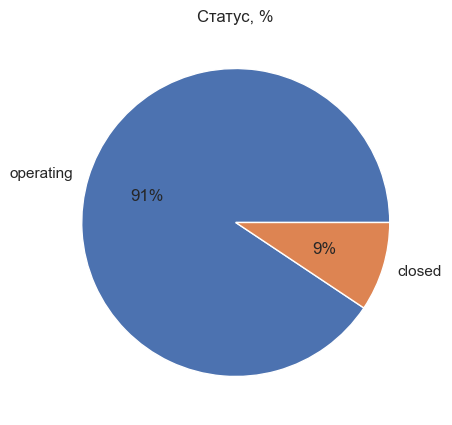

In [50]:
show_category_pie(startups_data, 'status', 'Статус')

В значениях поля **status** сильный дисбаланс. Стартапов в статусе ``operating`` - почти в 10 раз больше, чем ``closed``. Необходимо будет это учесть при подготовке данных для моделирования.

### Поле **category_list**

Поле **category_list** содержит составные данные. Это наименования категорий, которые разделены символом |. Выше по коду уникальные категории выделены в два списка: ``categories_data`` и ``categories_test``

In [51]:
def category_count(df):
    cat_data_count =  pd.DataFrame(df.sum()).sort_values(by=0, ascending=False)
    cat_data_count = cat_data_count.rename(columns={0: "Количество стартапов"})
    cat_data_count = cat_data_count.rename_axis('Категория')
    return cat_data_count

##### Поле **category_list** датасета ``startups_data``

In [52]:
category_count_data_df = category_count(categories_from_category_list_data)
category_count_data_df

,Количество стартапов
Категория,
Software,7017
Mobile,4401
Biotechnology,3668
E-Commerce,3308
unknown,2465
...,...
Fuel Cells,1
Baby Boomers,1
FPGA,1


In [53]:
len(category_count_data_df[category_count_data_df['Количество стартапов'] == 1])

24

##### Поле **category_list** датасета ``startups_test``

In [54]:
category_count_test_df = category_count(categories_from_category_list_test)
category_count_test_df

,Количество стартапов
Категория,
Software,1707
Mobile,1129
Biotechnology,873
E-Commerce,822
Curated Web,605
...,...
UV LEDs,1
Gift Registries,1
Twin-Tip Skis,1


In [55]:
len(category_count_test_df[category_count_test_df['Количество стартапов'] == 1])

79

В обоих датасетах большое количество категорий, которые встречаются только один раз. В ``startup_data`` - 24, в ``startup_test`` - 79

#### Оценка, насколько влияет (и влияет ли) категория на статус стартапа.

 Объединение таблицы с колонками по категориям с целевым признаком.

In [56]:
categories_data_and_status = categories_from_category_list_data\
    .merge((startups_data['status'] == startups_data['status'].unique()[1]) * 1, left_index=True, right_index=True)

In [57]:
category_status = None
for col in category_count_data_df.index[:]:
    d = pd.DataFrame({'Категория':[col],
        'Доля закрытых': [categories_data_and_status[categories_data_and_status[col] == 1]['status'].mean()],
        'Количество стартапов': [categories_data_and_status[categories_data_and_status[col] == 1]['status'].count()]})
    category_status = pd.concat([category_status,d])

pd.set_option('display.max_rows', None) # снимет ограничение на количество строк таблицы

#### Топ-10 самых популярных категорий и доля закрытых

In [58]:
category_status.sort_values('Количество стартапов', ascending=False).reset_index(drop=1).head(10)

,Категория,Доля закрытых,Количество стартапов
0,Software,0.08,7017
1,Mobile,0.09,4401
2,Biotechnology,0.06,3668
3,E-Commerce,0.08,3308
4,unknown,0.30,2465
5,Curated Web,0.17,2407
6,Social Media,0.13,2284
7,Enterprise Software,0.05,2193
8,Advertising,0.09,1985
9,Health Care,0.06,1885


#### Топ-10 самых успешных категорий

In [59]:
category_status[category_status['Доля закрытых'] == 0].reset_index(drop=1).sort_values('Количество стартапов', ascending=False).head(10)

,Категория,Доля закрытых,Количество стартапов
0,Business Analytics,0.00,66
1,K-12 Education,0.00,64
2,Mobile Analytics,0.00,46
3,Social Media Platforms,0.00,44
4,M2M,0.00,42
5,Text Analytics,0.00,35
6,Unifed Communications,0.00,33
7,Mobile Enterprise,0.00,33
8,Application Performance Monitoring,0.00,31
9,Coffee,0.00,27


#### Топ-10 самых неудачных категорий

In [60]:
category_status.sort_values('Доля закрытых', ascending=False).reset_index(drop=1).head(10)

,Категория,Доля закрытых,Количество стартапов
0,HDTV,1.00,1
1,Private Corrections,1.00,1
2,Niche Specific,1.00,2
3,Social,0.50,2
4,In-Flight Entertainment,0.50,6
5,Remediation,0.50,2
6,Social Activists,0.50,2
7,Racing,0.50,2
8,Anything Capital Intensive,0.50,2
9,Virtual Goods,0.38,13


In [61]:
pd.set_option('display.max_rows', 0) # вернёт ограничение на количество строк таблицы

##### Вывод:
- есть категории в которых абсолютно все стартапы - закрыты, есть категории в которых наоборот все стартапы продолжают деятельность;
- очевидно, что существует зависимость между успешностью стартапа и его категорией;
- больше всего закрывшихся стартапов с категорией unknown - не указанная категория;
- Business Analytics, Mobile Analytics, Text Analytics - входят в топ-5 категорий, у которых все стартапы успешны. Аналитика - удачное направление для вложений;
- Virtual Goods, Niche Specific и In-Flight Entertainment - самые неудачные категории;
- Software, Mobil, Biotechnolo - самые популярные категории.

In [62]:
#startups_data[startups_data['category_list'].str.contains('Labor Optimization')] # проверка статуса для конкретной категории

#### Общий список уникальных категорий из датасетов ``startups_data`` и ``startups_test``

In [63]:
categories = list(set(categories_test + categories_data))
len(categories)

860

In [64]:
pd.set_option('display.max_rows', None) # снимет ограничение на количество строк таблицы

categories_df = pd.DataFrame(categories, columns=['category']).sort_values(by='category',ascending=True) # посмотреть список категорий
#categories_df # необходимо включить для отображения полного списка категорий

In [65]:
pd.reset_option('display.max_rows', 0) # вернёт ограничение на количество строк таблицы

При просмотре уникальных категорий обнаружил категорию "Social + Mobile + Local", скорее всего у записей с такой категорией некорректный разделитель. Выше по коду внёс изменения.

##### Вывод:
- всего в обоих датасетах 860 уникальных категорий

### Поля **country_code**, **state_code**, **region**, **city**

In [66]:
geographical_columns = ['country_code', 'state_code', 'region', 'city']

In [67]:
top_values = 30 # top записей

In [68]:
geographical_data = startups_data.copy() # отдельный датасет, чтобы не изменять startups_data

In [69]:
# отберет только записи, которые попали в топ, остальным присвоит значение 'other'
for column in geographical_columns:
    top_categories = geographical_data[column].value_counts().head(top_values).index
    geographical_data[column] = geographical_data[column].apply(lambda value: value if value in top_categories else f'OUT_OF_TOP_{top_values}')

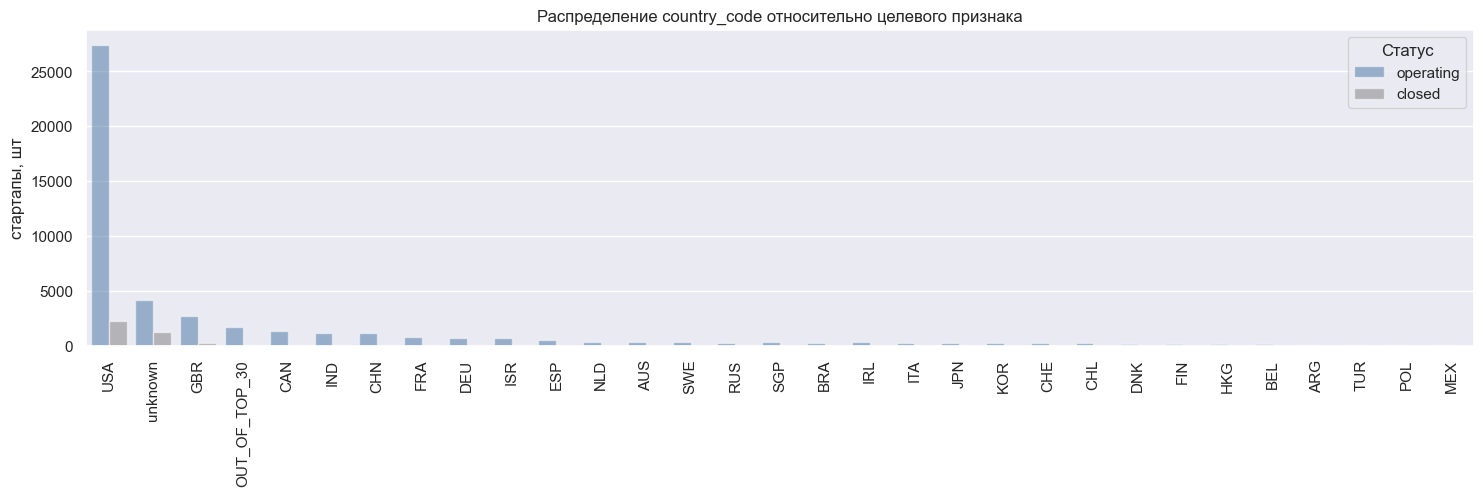

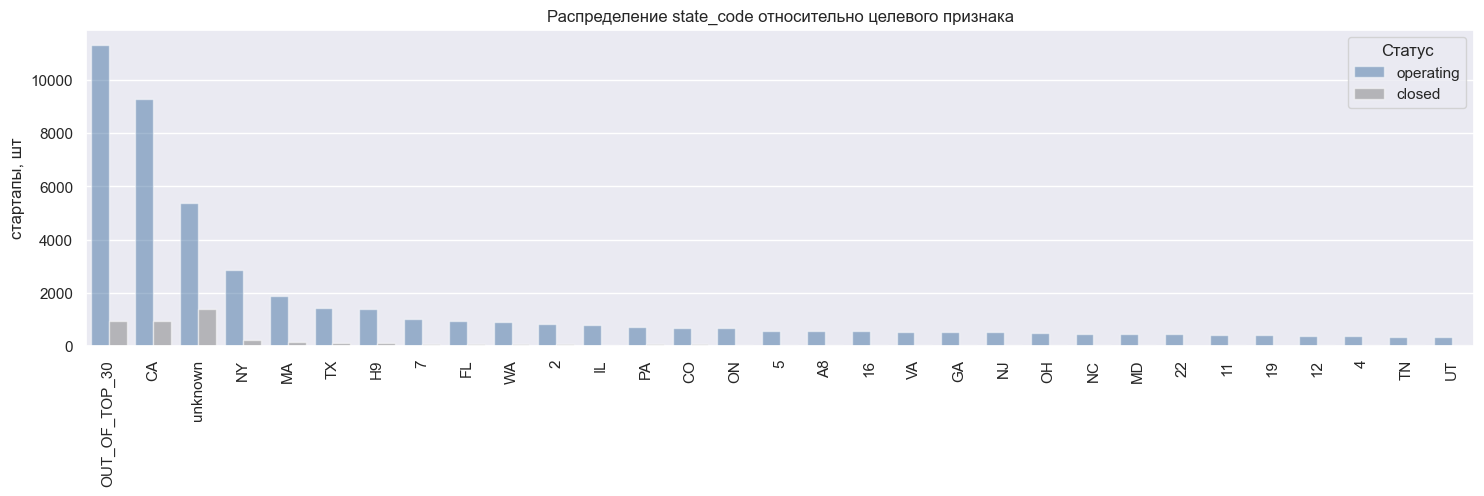

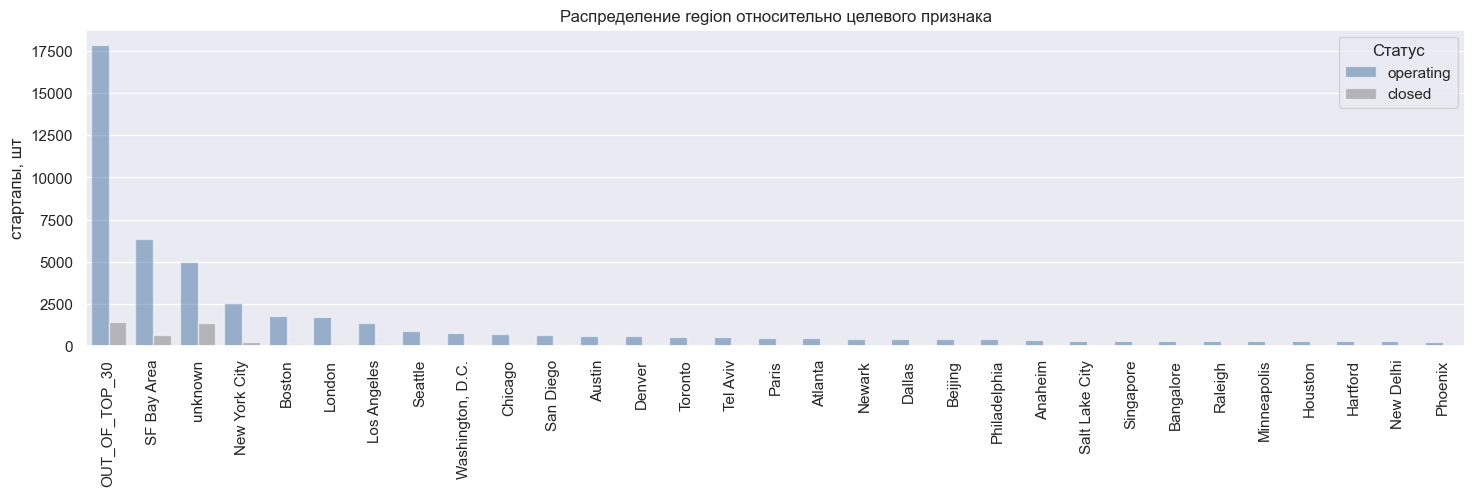

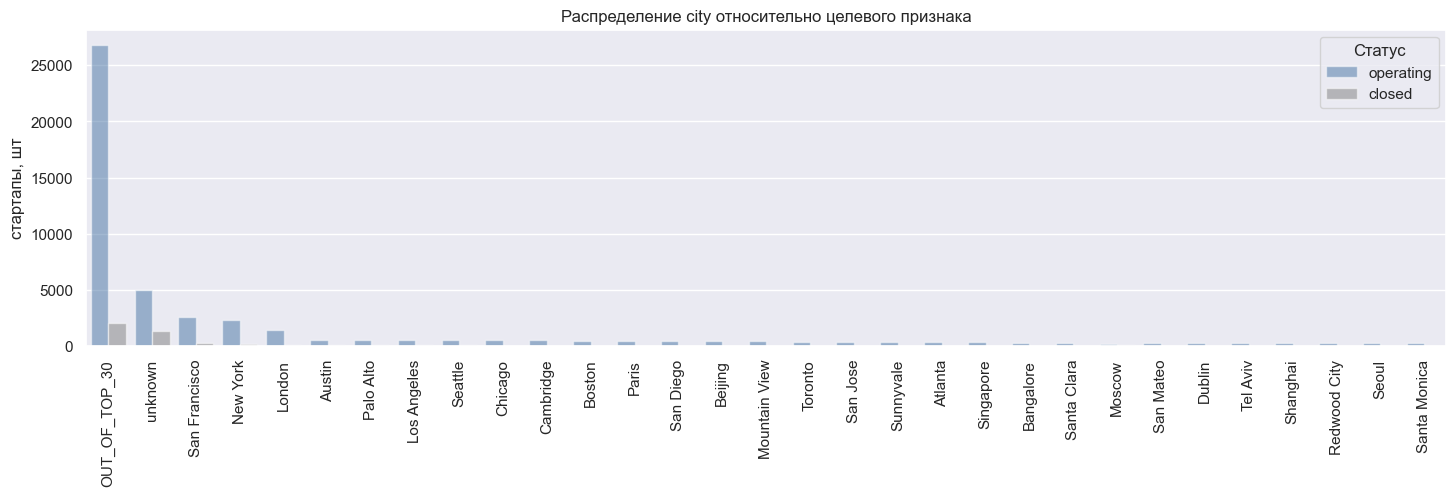

In [70]:
for column in geographical_columns:
    plt.figure(figsize=(15, 4))
    order = geographical_data[column].value_counts().index
    sns.countplot(data=geographical_data, x=column, hue='status', palette=[colors[1],colors[0]], order=order, alpha=0.5)
    plt.title(f'Распределение {column} относительно целевого признака')
    plt.xlabel('')
    plt.ylabel('cтартапы, шт')
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.legend(title='Cтатус')
    plt.show()

- больше всего стартапов открыто в США;
- Самые популярные города для стартапов - Сан-Франциско, Нью-Йорк, Лондон, Остин и Пло Альто;
- Популярные регионы - Сан-Франциско Bay Area, Нью-Йорк, Бостон, Лондон, Лос-Анжелес;
- Штаты - Калифорния, Нью-Йорк, Массачусетс.

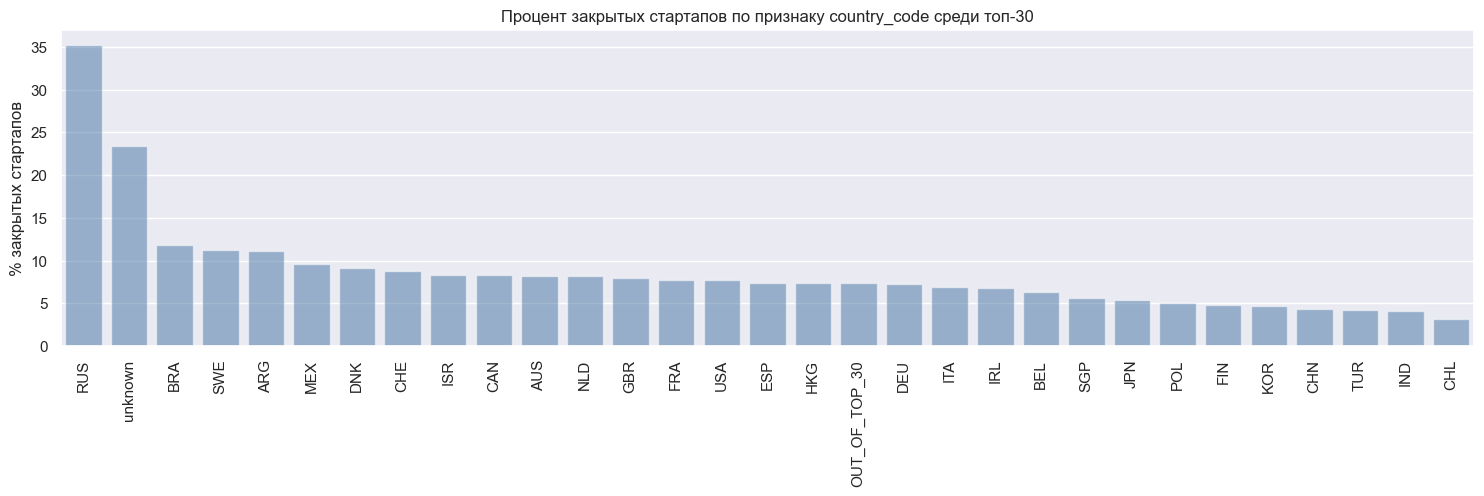

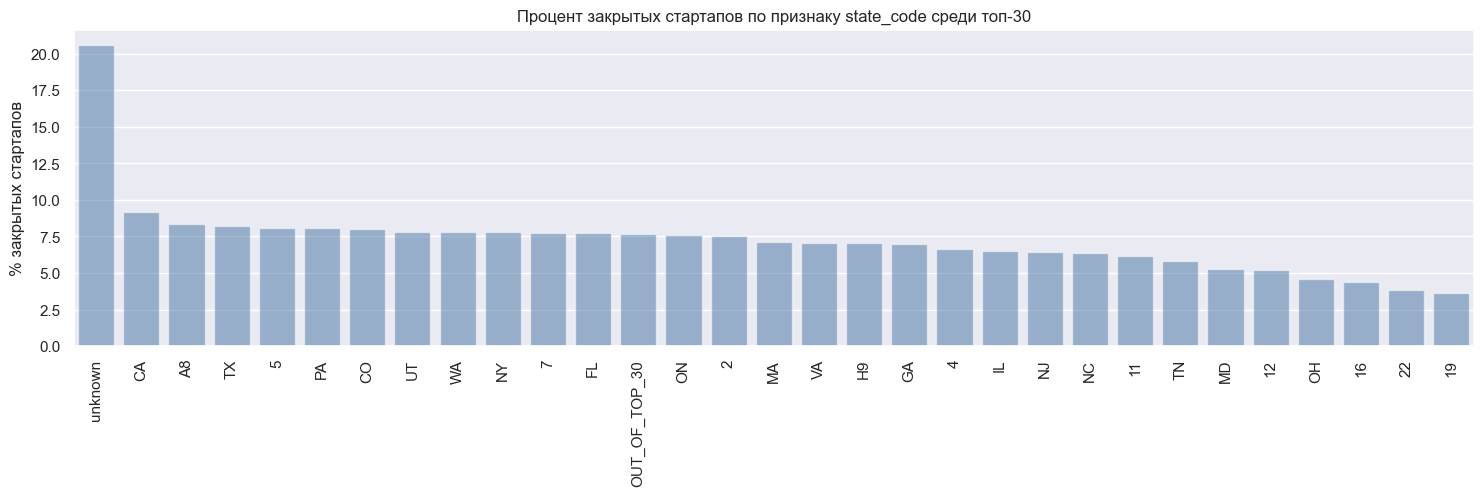

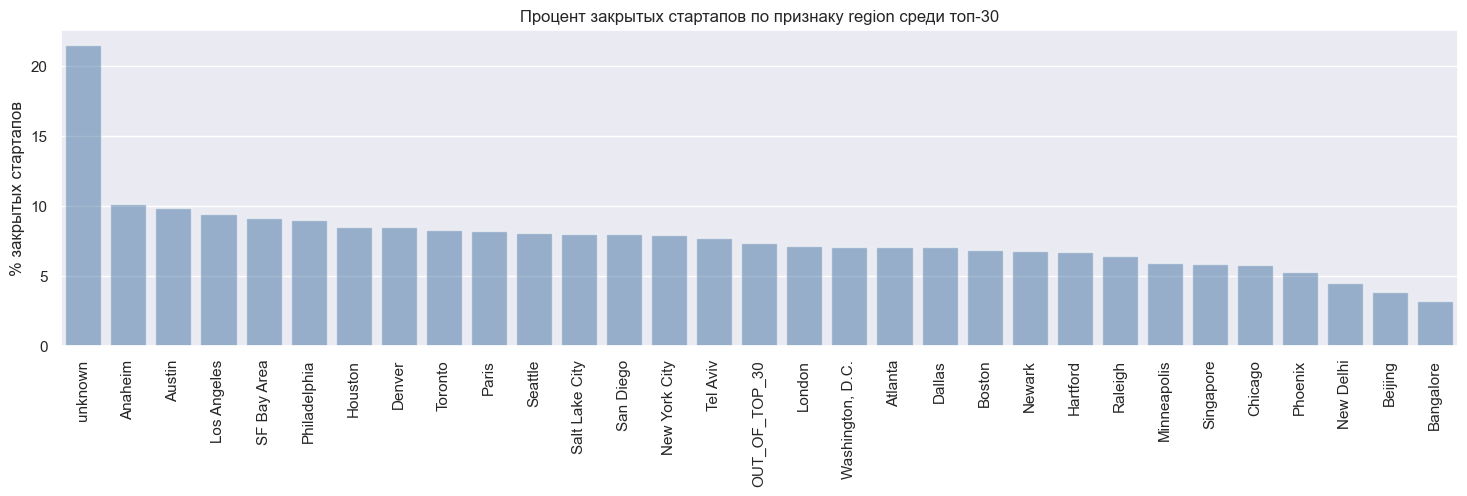

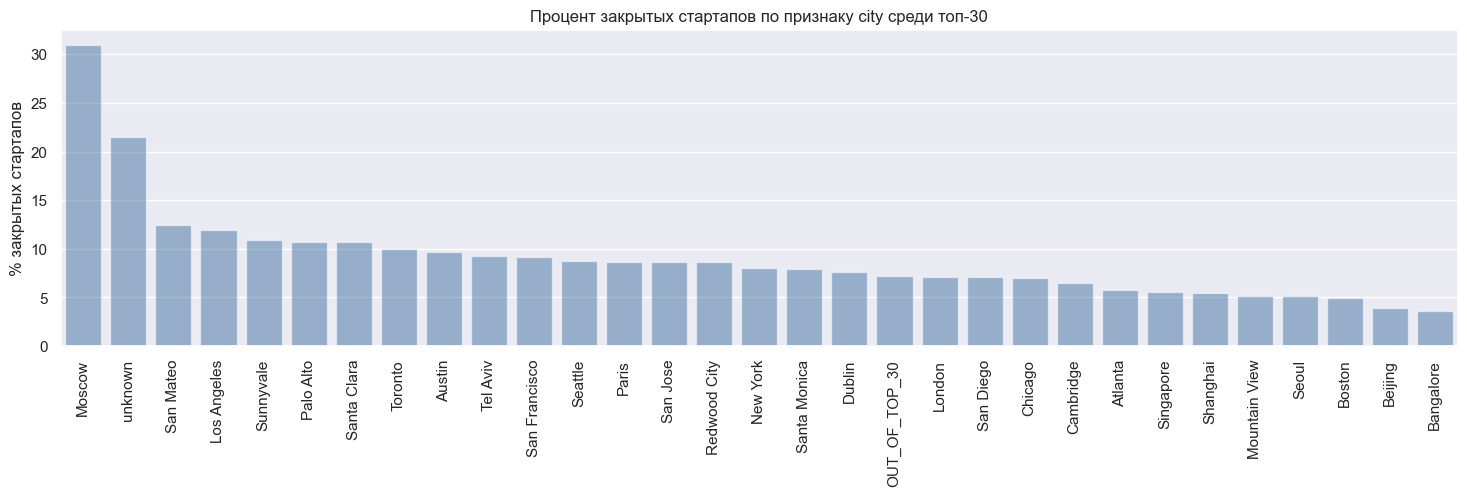

In [71]:
def plt_closed_percent(column, dataframe):        
    closed_percent = dataframe.groupby(column)['status'].apply(lambda x: (x == 'closed').mean() * 100).reset_index(name='closed_percent')    
    closed_percent = closed_percent.sort_values(by='closed_percent', ascending=False)
    
    plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=closed_percent, x=column, y='closed_percent', palette=[colors[1]], alpha=0.5)
    plt.title(f'Процент закрытых стартапов по признаку {column} среди топ-{top_values}')
    plt.xlabel('')
    plt.ylabel('% закрытых стартапов')
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.show()

for column in geographical_columns:
    plt_closed_percent(column, geographical_data)

- Примечательно, что в топ закрытых стартапов попала Россия (код страны RUS) и город в России - Москва (Moscow);
- 35% закрытых стартапов в России, 30% в Москве;
- state_code - не имеет очень выраженного лидера, первым идёт CA. Калифорния;
- регион - лидер Анахайм, Остин и Лос-Анджелес.

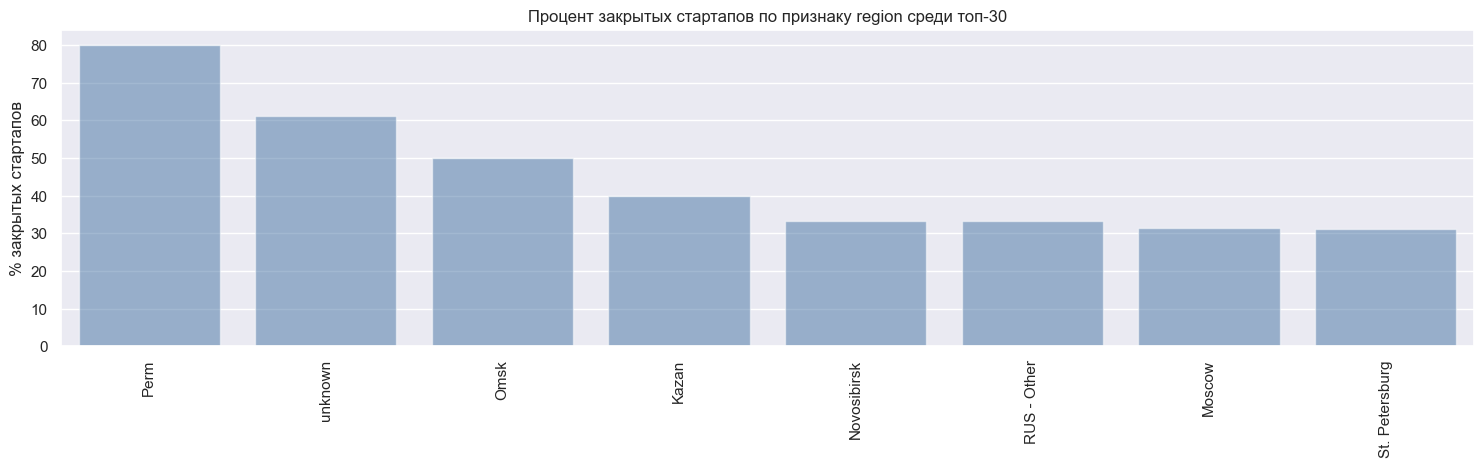

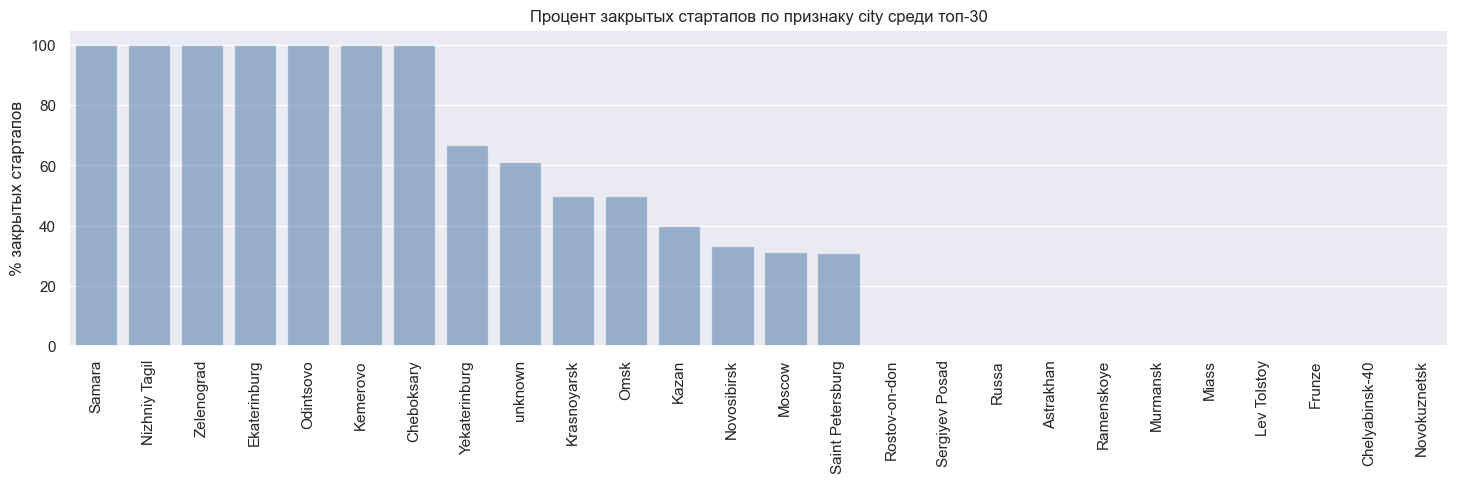

In [72]:
for column in ['region', 'city']:    
    plt_closed_percent(column, startups_data[startups_data['country_code'] == 'RUS'].copy())

**Вывод:**
- больше всего стартапов открыто в США;
- Самые популярные города для стартапов - Сан-Франциско, Нью-Йорк, Лондон, Остин и Пло Альто;
- Популярные регионы - Сан-Франциско Bay Area, Нью-Йорк, Бостон, Лондон, Лос-Анжелес;
- Штаты - Калифорния, Нью-Йорк, Массачусетс;
- Примечательно, что в топ закрытых стартапов попала Россия (код страны RUS) и город в России - Москва (Moscow);
- 35% закрытых стартапов в России, 30% в Москве;
- state_code - не имеет очень выраженного лидера, первым идёт CA. Калифорния;
- регион - лидер Анахайм, Остин и Лос-Анджелес;
- В Самаре, Нижнем Тагиле, Зеленограде, Екатеринбурге, Одинцово, Кемерово и Чебоксарах - 100% закрытие стартапов;
- В Санкт-Петербурге и Москве закрылась приемрно треть стартапов.

### Поля типа datetime - **first_funding_at**, **last_funding_at**

In [73]:
datetime_columns = ['first_funding_at', 'last_funding_at']

#### Генерация новых признаков на основе дат и анализ

In [74]:
def set_day_name(day):
    if day == 0:
        return 'Понедельник'
    elif day == 1:
        return 'Вторник'
    elif day == 2:
        return 'Среда'
    elif day == 3:
        return 'Четверг'
    elif day == 4:
        return 'Пятница'
    elif day == 5:
        return 'Суббота'
    else:
        return 'Воскресенье'
        
def add_date_columns(df, columns):
    for column_name in columns:
        df[f'{column_name}_day'] = df[column_name].dt.day
        df[f'{column_name}_dayofweek'] = df[column_name].dt.dayofweek                
        df[f'{column_name}_dayofweek_name'] = df[f'{column_name}_dayofweek'].apply(set_day_name) 
        df[f'{column_name}_month'] = df[column_name].dt.month
        df[f'{column_name}_year'] = df[column_name].dt.year
    return df
            
#data['publication_day'] = data['publication_day'].apply(set_day_name)    

In [75]:
add_date_columns(startups_data, datetime_columns).head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_day,first_funding_at_dayofweek,first_funding_at_dayofweek_name,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_dayofweek,last_funding_at_dayofweek_name,last_funding_at_month,last_funding_at_year
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,1,6,Воскресенье,5,2011,1,0,Понедельник,12,2014
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,4,1,Вторник,5,2010,25,1,Вторник,2,2014
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,20,0,Понедельник,8,2012,2,2,Среда,7,2014


In [76]:
add_date_columns(startups_test, datetime_columns).head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_day,first_funding_at_dayofweek,first_funding_at_dayofweek_name,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_dayofweek,last_funding_at_dayofweek_name,last_funding_at_month,last_funding_at_year
0,Crystalsol,Clean Technology,2819200.00,NIC,17,unknown,unknown,1,2009-07-01,2009-07-01,3501,1,2,Среда,7,2009,1,2,Среда,7,2009
1,JBI Fish & Wings,Hospitality,1287500.00,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,28,2,Среда,7,2010,28,2,Среда,7,2010
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,15,3,Четверг,5,2014,18,3,Четверг,9,2014


In [77]:
startups_data_0 = startups_data[startups_data['status'] == 'closed']  # только закрывшиеся
startups_data_1 = startups_data[startups_data['status'] == 'operating'] # только успешные

In [78]:
# конфигурация для типов - первое/последнее финансирование
conf_type = [
    {
        'type_name': 'первого',
        'type': 'first'
    },
    {
        'type_name': 'последнего',
        'type': 'last'
    }
]
# конфигурация для заполнения - день, день недели, месяц, год
conf_fill = [
    {
        'name': 'год',
        'name_0': 'году',
        'field': "funding_at_year",
        'rotate': 90,
        'sort_field': None
    },
    {
        'name': 'месяц',
        'name_0': 'месяцу',
        'field': "funding_at_month",
        'rotate': 0,
        'sort_field': None
    },
    {
        'name': 'день недели',
        'name_0': 'дню недели',
        #'field': "funding_at_dayofweek_name",
        'field': 'funding_at_dayofweek',
        'rotate': 0,
        #'sort_field': 'funding_at_dayofweek'
        'sort_field': None
    },
    {
        'name': 'число месяца',
        'name_0': 'числу месяца',
        'field': "funding_at_day",
        'rotate': 0,
        'sort_field': None
    }
]



Распределение первого финансирования



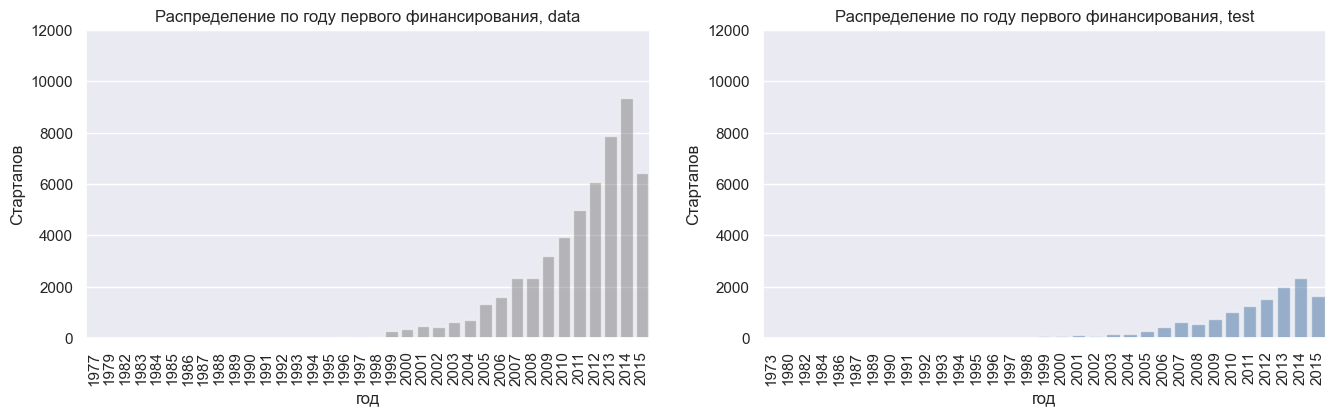

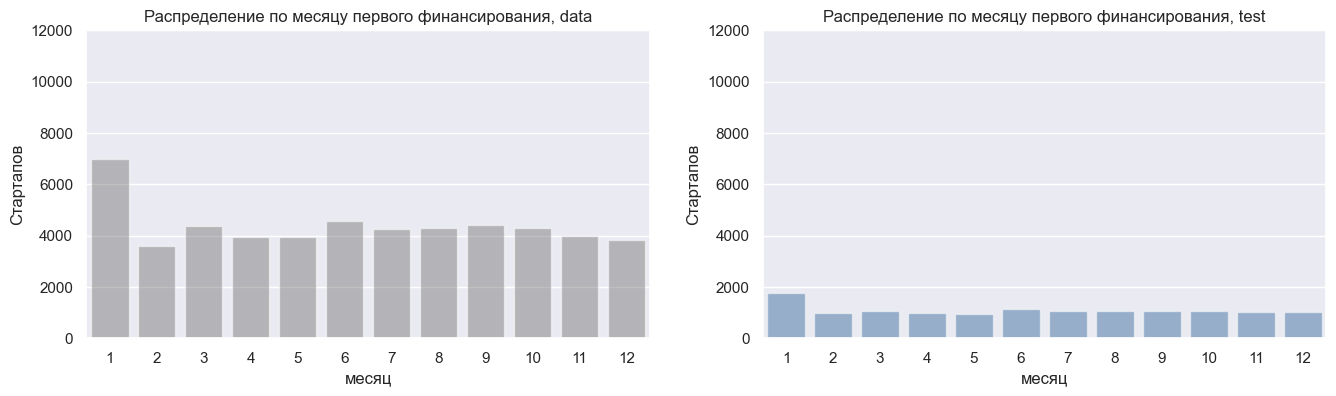

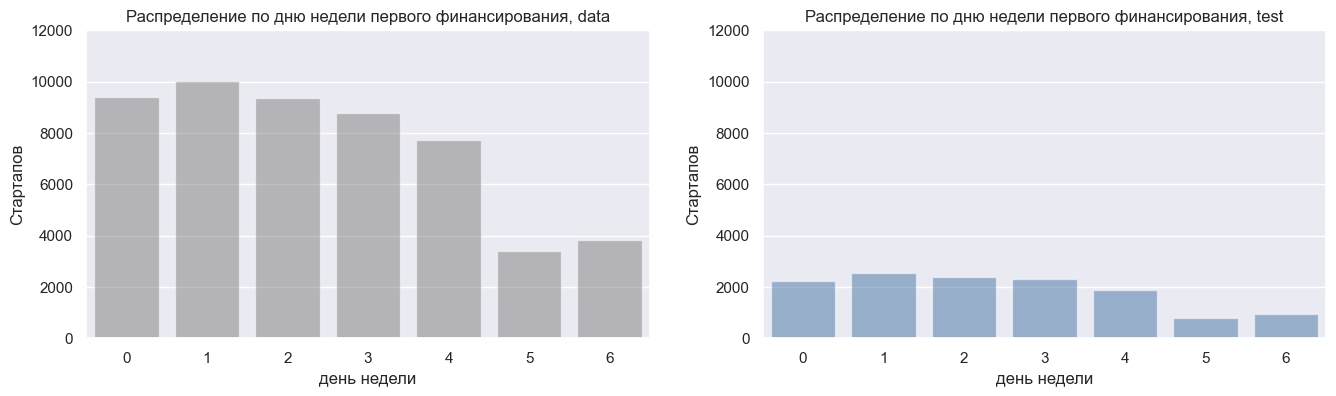

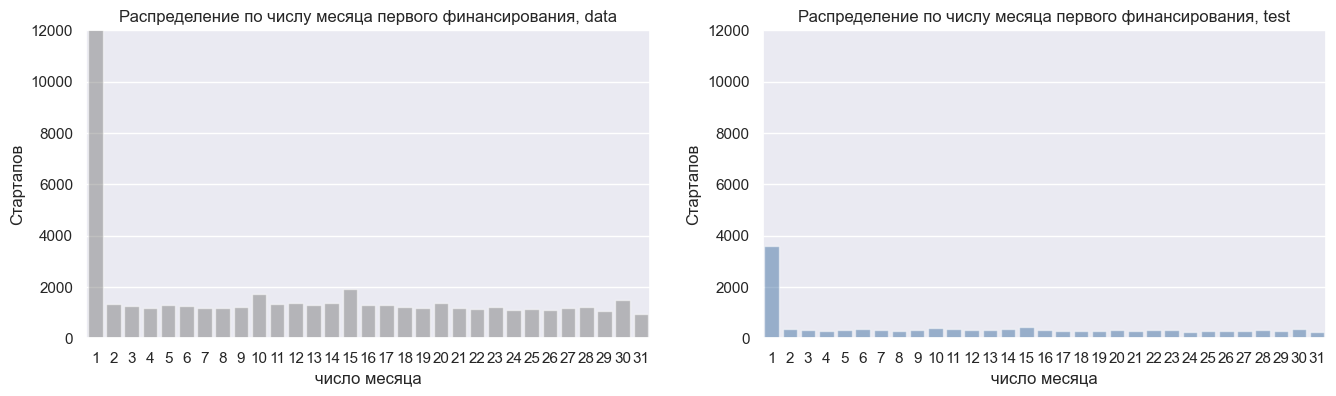



Распределение последнего финансирования



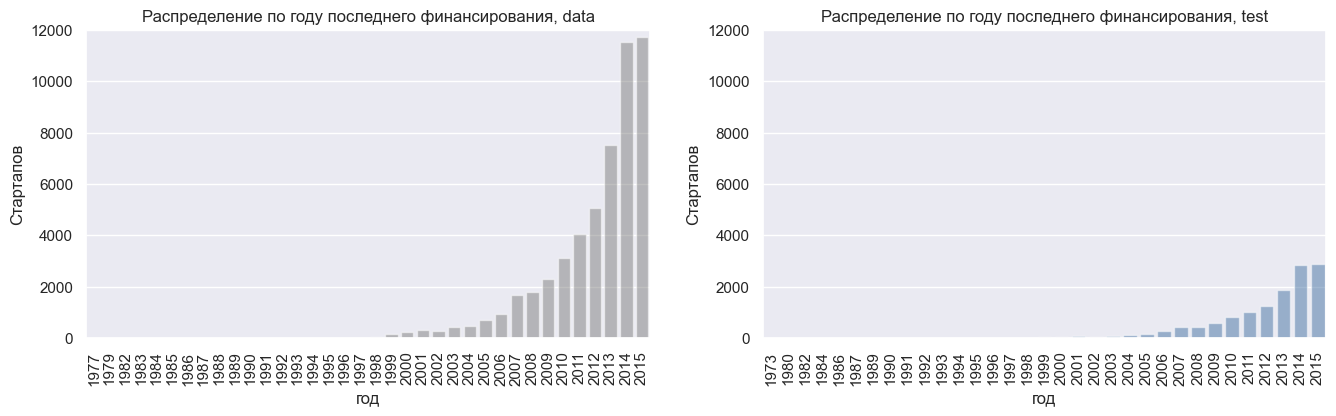

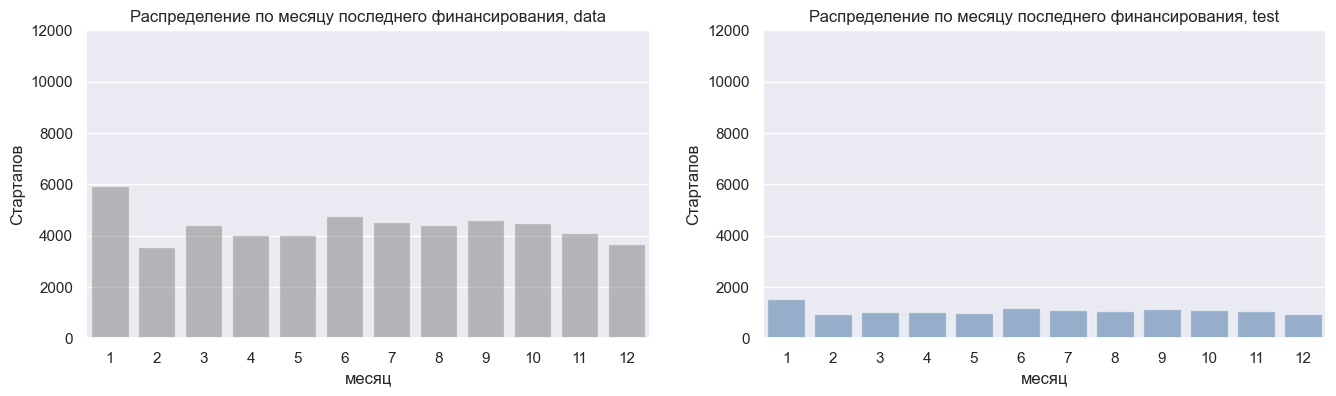

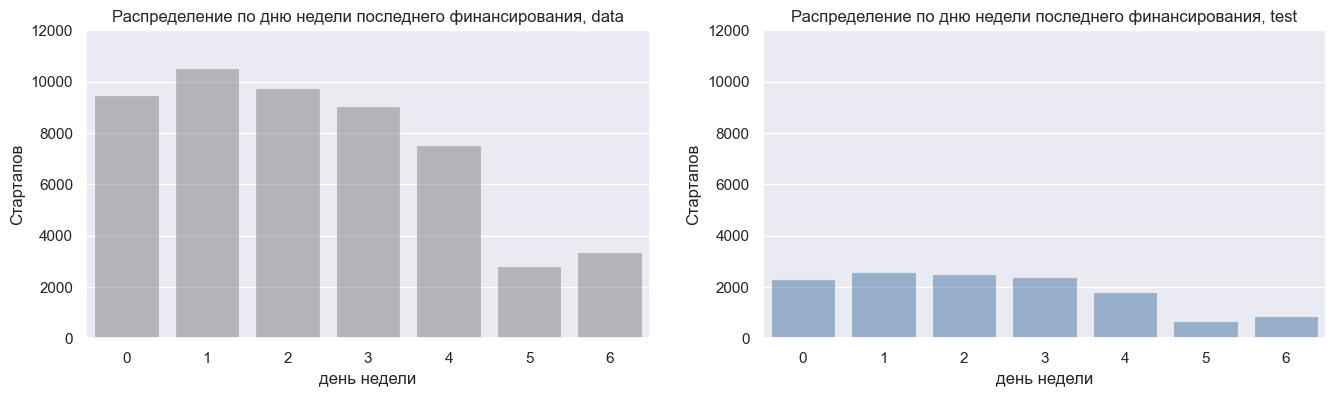

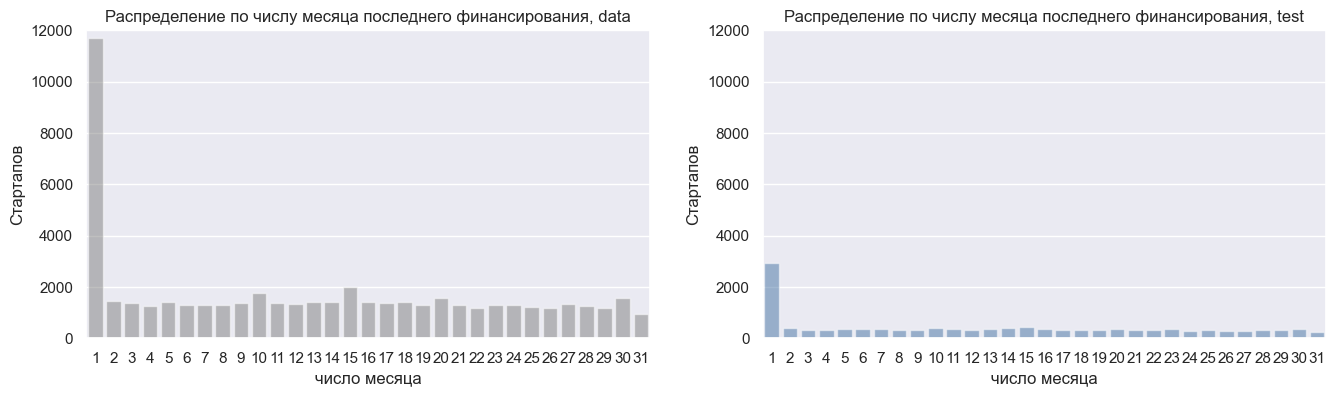

In [79]:
for t in conf_type:
    print(f'\n\nРаспределение {t["type_name"]} финансирования\n')
    for c in conf_fill:
        show_two_countplots(startups_data, startups_test, f'{t["type"]}_{c["field"]}', "Стартапов", c['name'],\
                        f'Распределение по {c["name_0"]} {t["type_name"]} финансирования, data',\
                        f'Распределение по {c["name_0"]} {t["type_name"]} финансирования, test', (0, 12000), c['rotate'], c['sort_field'], t["type"])

In [80]:
startups_data = startups_data.drop(columns=['last_funding_at_dayofweek_name', 'first_funding_at_dayofweek_name'])
startups_test = startups_test.drop(columns=['last_funding_at_dayofweek_name', 'first_funding_at_dayofweek_name'])

**Вывод:**
- начиная с 70-х годов шёл рост количества новых стартапов, начиная с начала нулевых рост ускорился и вплоть до 2015 года увеличивался. За опорные даты приняты даты первого и последнего финансирования;
- в 2015 году наметилось уменьшение количества первого финансирования стартапов, возможно это связано с тем, что данные содержат записи до 2015 года, хотя заявлен 2018;
- чаще всего первое и последнее финансирование было в январе;
- день недели имеет значение - обычно финансирование осуществлялось в будние дни, но несколько больше во вторник, несколько меньше в пятницу;
- в подавляющем числе случаев финансирование было 1 числа месяца.

## Разведочный анализ количественного признака с дискретным характером

### Поле **funding_rounds** (количественный, с дискретным характером)

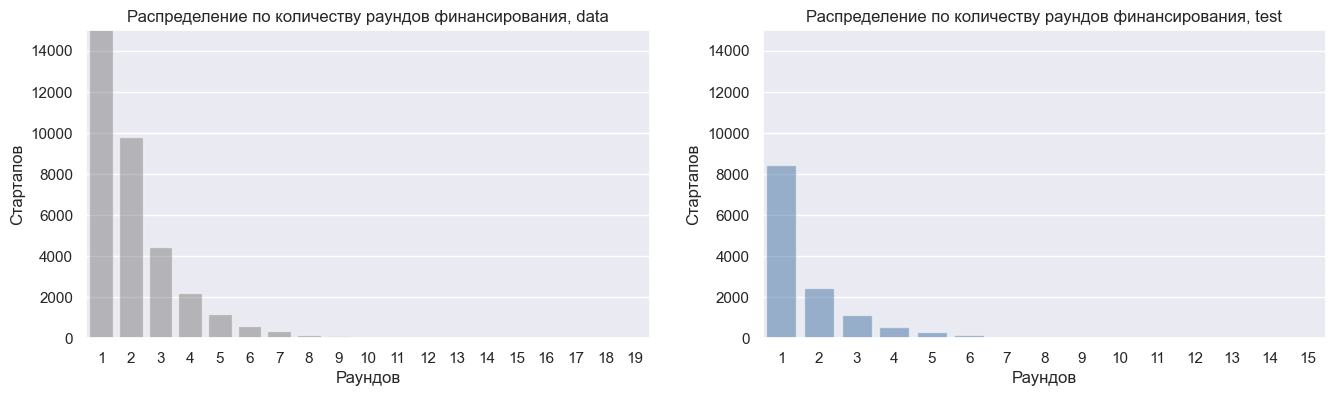

In [81]:
show_two_countplots(startups_data, startups_test, 'funding_rounds', "Стартапов", 'Раундов',\
                        f'Распределение по количеству раундов финансирования, data',\
                        f'Распределение по количеству раундов финансирования, test', (0, 15000))

Распределение раундов финансирования более 7

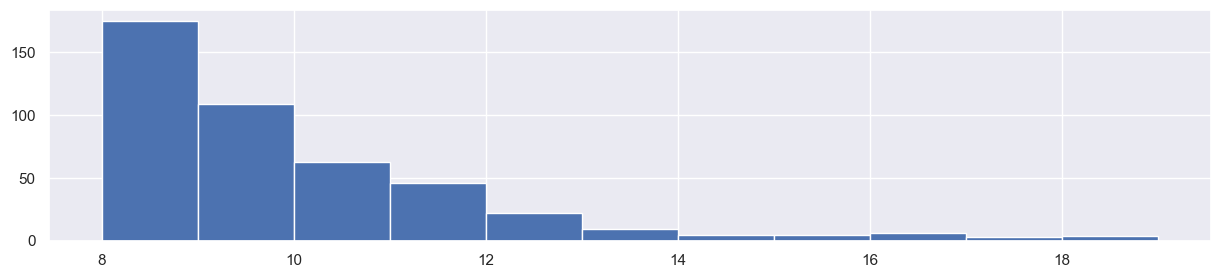

In [82]:
startups_data[startups_data['funding_rounds'] > 7]['funding_rounds'].hist(figsize=(15,3), bins=11) ;
#startups_data.pivot_table(index='funding_rounds', values='name', aggfunc='count').sort_values(by=['funding_rounds'],ascending=True)

In [83]:
funding_rounds = startups_data[['funding_rounds','funding_total_usd']]\
    .groupby(['funding_rounds'])['funding_total_usd']\
    .agg(['mean','median','max','min','count'])
funding_rounds

,mean,median,max,min,count
funding_rounds,,,,,
1,7106521.63,1300000.00,10664943639.00,1.00,33489
2,12796066.85,2600000.00,5162513431.00,68.00,9816
3,22092652.16,6800000.00,4240250000.00,5000.00,4450
4,33918012.32,14350000.00,1159803496.00,13933.00,2189
5,76598522.97,25428000.00,30079503000.00,90000.00,1168
6,84567812.57,35743437.50,5820000000.00,21330.00,616
7,102993466.75,46020414.00,4812000000.00,145000.00,341
8,123297237.75,67300000.00,1567504319.00,666953.00,175
9,133031268.83,60200000.00,1471000000.00,600000.00,109


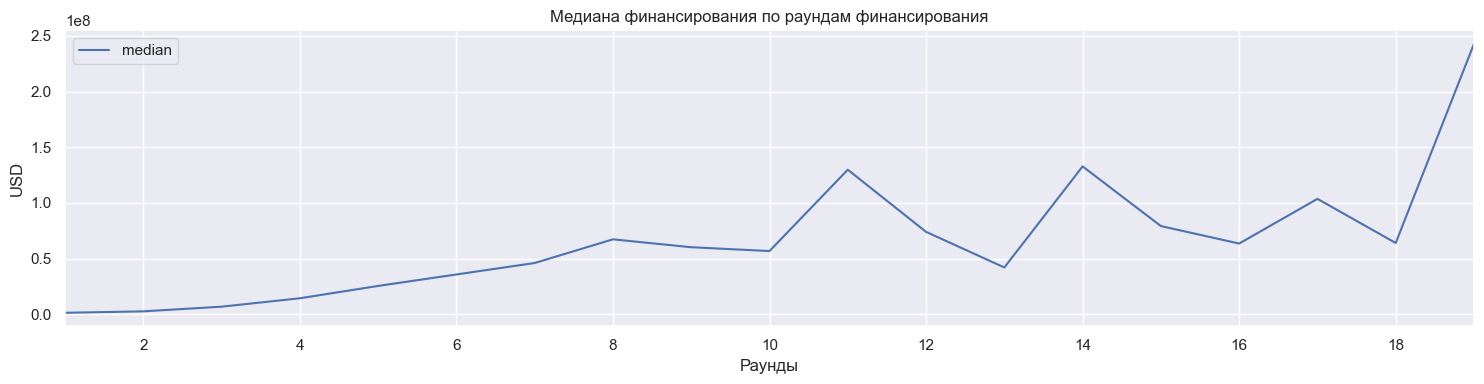

In [84]:
funding_rounds[['median']].plot(figsize=(15,4)) ;
plt.title('Медиана финансирования по раундам финансирования')
plt.xlabel('Раунды')
plt.ylabel('USD')
plt.xlim([1, 19])
plt.tight_layout()
plt.show()

С увеличением количества раундов до 8 идёт рост общей суммы финансирования. От 8 до 10 примерно на одном уровне. Дальше количество стартапов для раундов меньше 100, выборка уже не позволяет провести анализ.

In [85]:
#startups_data[['funding_rounds','funding_total_usd','status']]

In [86]:
funding_rounds_status = startups_data[['funding_rounds','funding_total_usd','status']]\
    .groupby(['funding_rounds','status'])['funding_total_usd']\
    .agg(['mean','median','max','min','count'])
funding_rounds_status

mean       median            max  \
funding_rounds status                                               
1              closed      5849065.26   1300000.00   915000000.00   
               operating   7265511.82   1300000.00 10664943639.00   
2              closed     13085560.45   2600000.00   870578950.00   
               operating  12772463.36   2600000.00  5162513431.00   
3              closed     19786691.60   8208261.50   158700000.00   
               operating  22212583.92   6739123.50  4240250000.00   
4              closed     33291661.28  19800000.00   374000000.00   
               operating  33947681.58  14166504.00  1159803496.00   
5              closed     36990058.38  35638334.00   156304548.00   
               operating  78185683.17  25400000.00 30079503000.00   
6              closed     47654299.08  21688477.00   365872959.00   
               operating  86129297.91  36962500.00  5820000000.00   
7              closed     37405083.67  23138876.00   130003458.00   
               operating 104771465.09  47825026.00  4812000000.00   
8              closed    187192677.38  36004847.00  1567504319.00   
               operating 118169825.92  67438045.50  1185585000.00   
9              closed     55759023.25  11554116.50   196664126.00   
               operating 135974973.42  63000000.00  1471000000.00   
10             closed     59463635.00  59463635.00    59463635.00   
               operating 129409201.18  55812563.50  1315500000.00   
11             closed     58953398.50  58953398.50   116568047.00   
               operating 344605903.93 131585890.50  2425700000.00   
12             operating 127747251.68  74016526.50   818799995.00   
13             operating 995029178.11  42027500.00  8207450000.00   
14             operating 376862875.20 132787385.00  1158040000.00   
15             operating  80062119.64  79209599.00   204892075.00   
16             operating 320327393.00  63505195.00  1671557162.00   
17             operating 132608565.00 103662749.00   247545839.00   
18             operating  80691414.00  63997160.00   138845088.00   
19             operating 242948825.00 242948825.00   242948825.00   

                                  min  count  
funding_rounds status                         
1              closed            2.00   3759  
               operating         1.00  29730  
2              closed         4500.00    740  
               operating        68.00   9076  
3              closed        30000.00    220  
               operating      5000.00   4230  
4              closed       435000.00     99  
               operating     13933.00   2090  
5              closed      1200000.00     45  
               operating     90000.00   1123  
6              closed       867000.00     25  
               operating     21330.00    591  
7              closed       457282.00      9  
               operating    145000.00    332  
8              closed      1455000.00     13  
               operating    666953.00    162  
9              closed      3263734.00      4  
               operating    600000.00    105  
10             closed     59463635.00      1  
               operating   1664000.00     62  
11             closed      1338750.00      2  
               operating   5650000.00     44  
12             operating   1507200.00     22  
13             operating   6280622.00      9  
14             operating   9050000.00      5  
15             operating  12032658.19      5  
16             operating   4845320.00      6  
17             operating  46617107.00      3  
18             operating  39231994.00      3  
19             operating 242948825.00      1

Начиная с 12 раунда стартапы не закрываются - очевидно число раундов по статистике влияет на закрытие стартапов.

Разделение на два датафрейма - operating/closed, признак median

In [87]:
operating_median = pd.DataFrame(funding_rounds_status.query('status == "operating"')['median']).droplevel(1, axis=0)
closed_median = pd.DataFrame(funding_rounds_status.query('status == "closed"')['median']).droplevel(1, axis=0)

sum_operating = funding_rounds_status.query('status == "operating"')['count'].sum()
sum_closed = funding_rounds_status.query('status == "closed"')['count'].sum()

operating_count = pd.DataFrame(funding_rounds_status.query('status == "operating"')['count']).droplevel(1, axis=0)
operating_count['count'] = operating_count['count'] / sum_operating * 100
closed_count = pd.DataFrame(funding_rounds_status.query('status == "closed"')['count']).droplevel(1, axis=0)
closed_count['count'] = closed_count['count'] / sum_closed * 100

In [88]:
operating_closed_median = pd.merge(operating_median, closed_median, how='left', left_index=True, right_index=True, suffixes=('_operating','_closed'))\
    .fillna(0)

operating_closed_count = pd.merge(operating_count, closed_count, how='left', left_index=True, right_index=True, suffixes=('_operating','_closed'))\
    .fillna(0)

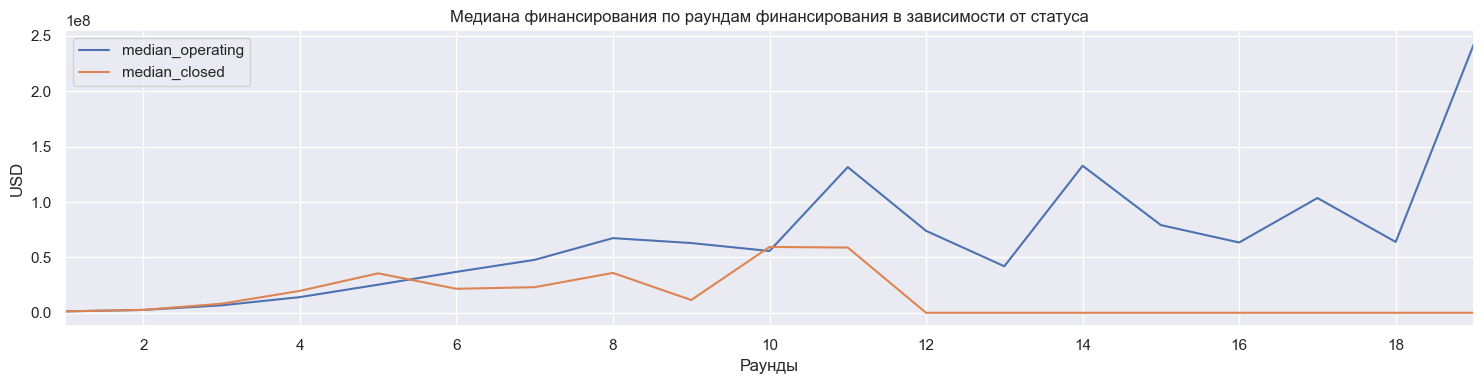

In [89]:
operating_closed_median.plot(figsize=(15, 4)) ;
plt.title('Медиана финансирования по раундам финансирования в зависимости от статуса')
plt.xlabel('Раунды')
plt.ylabel('USD')
plt.xlim([1, 19])
plt.tight_layout()
plt.show()

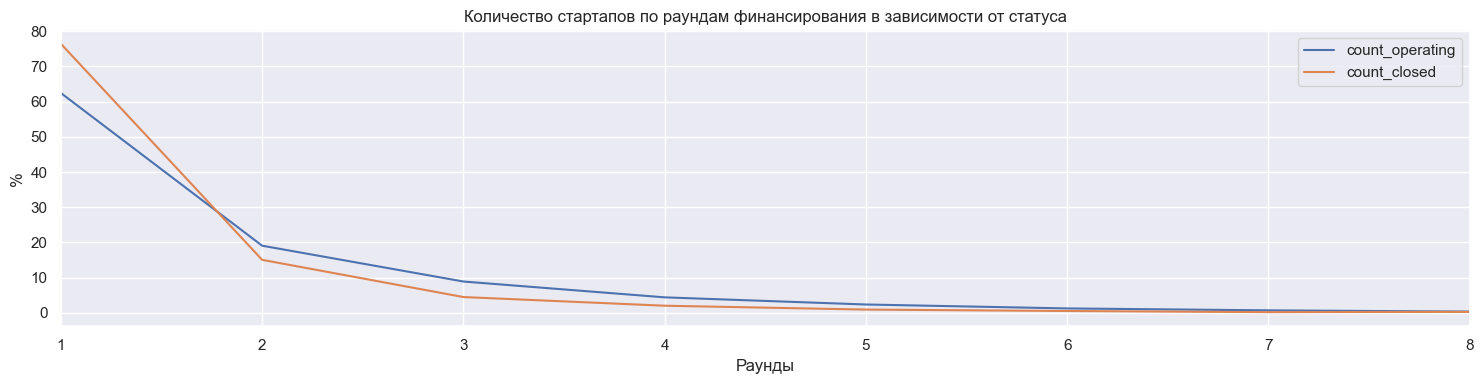

In [90]:
operating_closed_count.plot(figsize=(15, 4)) ;
plt.title('Количество стартапов по раундам финансирования в зависимости от статуса')
plt.xlabel('Раунды')
plt.ylabel('%')
plt.xlim([1, 8])
plt.tight_layout()
plt.show()

**Вывод:**
- Подавляющее большинство стартапов проходят лишь один раунд финансирования;
- Как правило раундов не более 6-7, очень редко больше;
- Встречаются стартапы у которых было 19 раундов финансирования (вполне может быть);
- Начиная с 12 раунда стартапы не закрываются - очевидно число раундов по статистике влияет на закрытие стартапов;
- С увеличением количества раундов до 8 идёт рост общей суммы финансирования. От 8 до 10 примерно на одном уровне. Дальше количество стартапов для раундов меньше 100, выборка уже не позволяет провести анализ.

## Разведочный анализ количественных признаков

In [91]:
numerical_categories = ['funding_total_usd', 'funding_mln', 'lifetime', 'lifetime_years', 'funding_rounds']

Для удобства работы с большими числами, добавление нового поля - ``funding_mln``

In [92]:
startups_data['funding_mln'] = round(startups_data['funding_total_usd']/1000000)
startups_test['funding_mln'] = round(startups_test['funding_total_usd']/1000000)

Для удобства работы с большими числами, добавление нового поля - ``lifetime_years``

In [93]:
startups_data['lifetime_years'] = round(startups_data['lifetime']/365)
startups_test['lifetime_years'] = round(startups_test['lifetime']/365)

### Количественные датасет ``startups_data``

#### Объем финансирования в usd

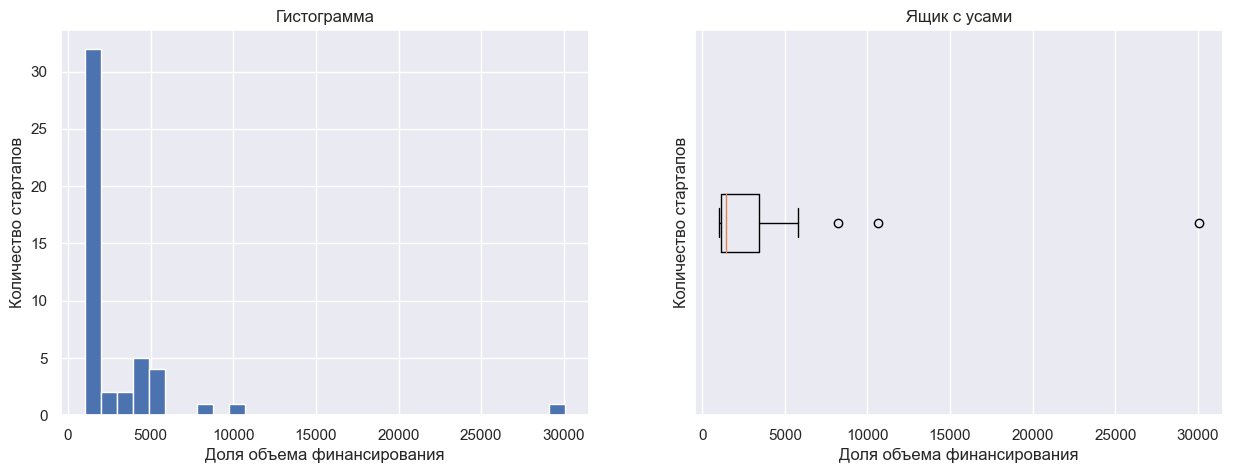

In [94]:
show_numeric_bplt_hist(startups_data[startups_data['funding_mln'] > 1000], 'funding_mln', 'Доля объема финансирования', 'Количество стартапов', 30)

На диаграмме видно три выброса, начиная от 6 млрд. usd

In [95]:
startups_data[startups_data['funding_mln'] > 6000]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_day,first_funding_at_dayofweek,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_dayofweek,last_funding_at_month,last_funding_at_year,funding_mln,lifetime_years
4557,Uber,Automotive|Design|Limousines|Public Transporta...,8207450000.00,operating,USA,CA,SF Bay Area,San Francisco,13,2009-08-01,2015-09-07,3228,1,5,8,2009,7,0,9,2015,8207.00,9.00
21241,Cambridge Technology Group,Consulting|Product Development Services|Produc...,10664943639.00,operating,unknown,unknown,unknown,unknown,1,2000-01-01,2000-01-01,10958,1,5,1,2000,1,5,1,2000,10665.00,30.00
39186,Verizon Communications,Communications Infrastructure|Information Tech...,30079503000.00,operating,USA,NY,New York City,New York,5,2010-01-26,2014-02-28,12505,26,1,1,2010,28,4,2,2014,30080.00,34.00


Все три - реально компании-гиганты. Финансирование правдоподобно. Тем не менее - для модели лучше исключить их из датасета.

#### Продолжительность существования

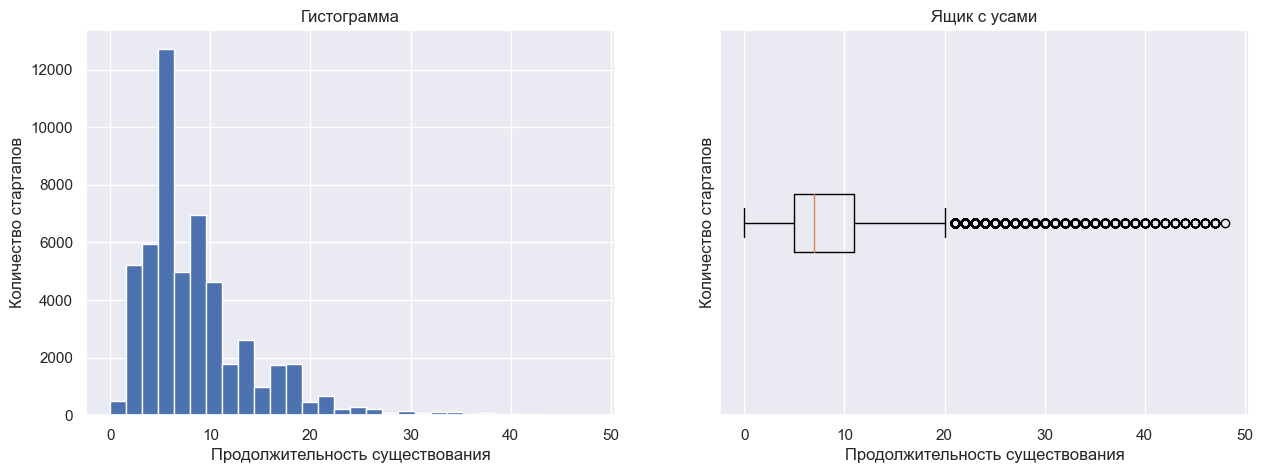

In [96]:
show_numeric_bplt_hist(startups_data, 'lifetime_years', 'Продолжительность существования', 'Количество стартапов', 30)

In [97]:
startups_test[startups_test['lifetime_years'] > 20].sort_values(by='lifetime', ascending=False).head(3)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_day,first_funding_at_dayofweek,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_dayofweek,last_funding_at_month,last_funding_at_year,funding_mln,lifetime_years
6314,Quad/Graphics,Local Businesses,1900000000.00,USA,WI,Milwaukee,Sussex,1,2014-04-28,2014-04-28,17167,28,0,4,2014,28,0,4,2014,1900.00,47.00
13072,Cardinal Health,Health and Wellness|Health Care|Hospitals,1500000000.00,USA,OH,"Columbus, Ohio",Dublin,1,2006-08-16,2006-08-16,17167,16,2,8,2006,16,2,8,2006,1500.00,47.00
4406,First Data Corporation,Payments|Trading,3500000000.00,USA,GA,Atlanta,Atlanta,1,2014-07-03,2014-07-03,17167,3,3,7,2014,3,3,7,2014,3500.00,47.00


Стартапы с продолжительностью жизни 47 лет похожи на выбросы, но такие компании действительно существуют - и основаны действительно в 1971 году. Quad, First Data и Cardinal Health - легко находятся в Internet. First Data Corp в 2019 году была поглощена компанией Fiserv, которая тоже не молода - основана в 1984 году.

In [98]:
years_0 = startups_data[startups_data['lifetime'] < 365].sort_values(by='lifetime', ascending=False)['name'].count()

In [99]:
years_20 = startups_data[startups_data['lifetime_years'] > 20].sort_values(by='lifetime_years', ascending=False)['name'].count()

In [100]:
print(f'Стартапов с продолжительностью жизни до 1 года: {years_0} шт,  {round(years_0 / len(startups_data) * 100, 2)}%')
print(f'Стартапов с продолжительностью жизни более 20 лет: {years_20} шт,  {round(years_20 / len(startups_data) * 100, 2)}%')

Стартапов с продолжительностью жизни до 1 года: 81 шт,  0.15%
Стартапов с продолжительностью жизни более 20 лет: 2214 шт,  4.22%


В сумме таких стартапов менее 5% на весь датасет.

### Количественные датасет ``startups_test``

#### Объем финансирования в usd

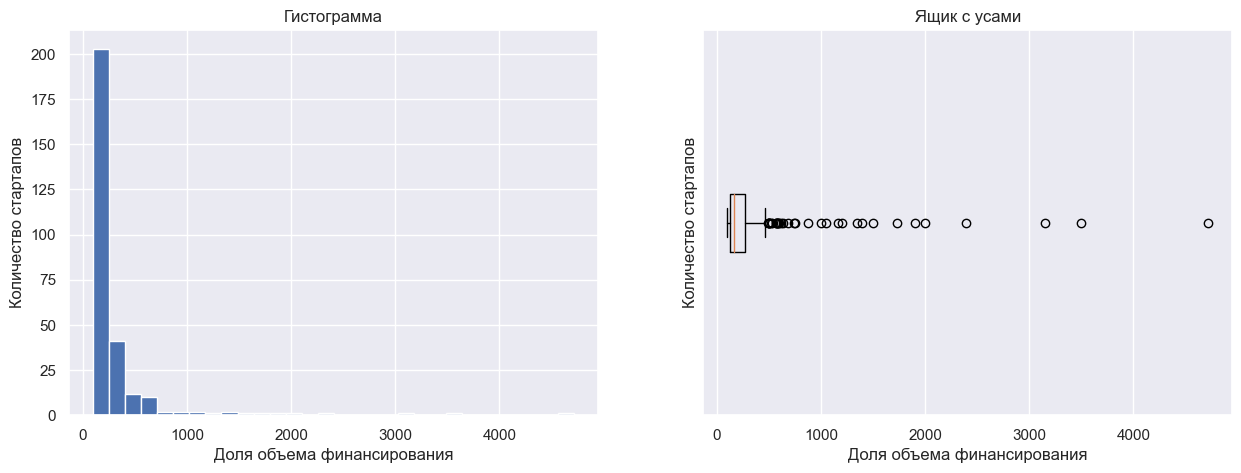

In [101]:
show_numeric_bplt_hist(startups_test[startups_test['funding_mln'] > 100], 'funding_mln', 'Доля объема финансирования', 'Количество стартапов', 30)

In [102]:
startups_test[startups_test['funding_mln'] > 4500]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_day,first_funding_at_dayofweek,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_dayofweek,last_funding_at_month,last_funding_at_year,funding_mln,lifetime_years
6448,MediaVast,Advertising|Broadcasting|Content,4715000000.00,USA,NY,New York City,New York,2,2003-06-30,2006-05-17,6940,30,0,6,2003,17,2,5,2006,4715.00,19.00


Выбросом выглядит реально существующая Software & Tech Services компания.

#### Продолжительность существования

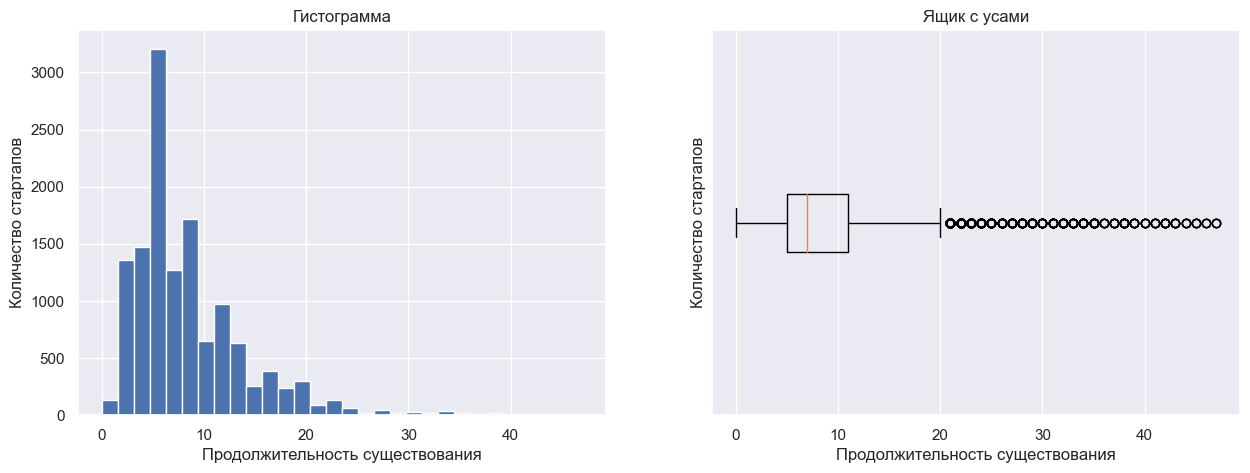

In [103]:
show_numeric_bplt_hist(startups_test, 'lifetime_years', 'Продолжительность существования', 'Количество стартапов', 30)

In [104]:
years_0_test = startups_test[startups_test['lifetime'] < 365].sort_values(by='lifetime', ascending=False)['name'].count()
years_20_test = startups_test[startups_test['lifetime_years'] > 20].sort_values(by='lifetime_years', ascending=False)['name'].count()

In [105]:
print(f'Стартапов с продолжительностью жизни до 1 года: {years_0_test} шт,  {round(years_0_test / len(startups_test) * 100, 2)}%')
print(f'Стартапов с продолжительностью жизни более 20 лет: {years_20_test} шт,  {round(years_20_test / len(startups_test) * 100, 2)}%')

Стартапов с продолжительностью жизни до 1 года: 17 шт,  0.13%
Стартапов с продолжительностью жизни более 20 лет: 531 шт,  4.05%


Так же как в startups_data - продолжительность жизни как правило от 0 до 20 лет, более 20 лет ~ 4% компаний.

**Вывод:**
- продолжительность жизни стартапа как правило от 0 до 20 лет, более 20 лет ~ 4% компаний;
- Доля закрытых стартапов падает с количеством раундов финансирования;
- Общая сумма финансирования растёт с каждым раундом у действующих и перестаёт расти после 5го раунда у закрытых стартапов;
- После 6 раунда финансирования стартапы почти не закрываются;
- Размер финансирования - находится в пределах 30 млрд. usd, медиана - 2 млн. usd, среднее - 18,7 млн. usd;
- Максимальное количество раундов финансирования - 19;
- Большинство значений общей суммы финансировнаия от 336 тыс. до 10 млн. usd;
- Большинство стартапов имеют 1-2 раунда финансирования;
- На диаграммах виден большой разброс в числовых данных. Необходимо учесть это при обучении модели, использовать scaler.

## Вывод по EDA

**Категориальные признаки:**
- В значениях поля **status** сильный дисбаланс. Стартапов в статусе ``operating`` - почти в 10 раз больше, чем ``closed``. Необходимо будет это учесть при подготовке данных для моделирования.


В датасете ``startups_data``:
- все имена стартапов уникальные - 52516 штук,
- уникальных наборов категорий - 22106,
- 135 кодов стран,
- 301 код штата,
- 1037 регионов,
- 4478 городов.
- Всего категорий из category_list - 856.


В датасете ``startups_test``:
- все имена стартапов уникальные - 13125 штук,
- уникальных наборов категорий - 6207,
- 97 кодов стран,
- 236 код штата,
- 689 регионов,
- 2118 городов.
- Всего категорий из category_list - 796.


Датасет ``startups_data``:
- больше всего стартапов открыто в США;
- самые популярные города для стартапов - Сан-Франциско, Нью-Йорк, Лондон, Остин и Пло Альто;
- популярные регионы - Сан-Франциско Bay Area, Нью-Йорк, Бостон, Лондон, Лос-Анжелес;
- штаты - Калифорния, Нью-Йорк, Массачусетс;
- примечательно, что в топ закрытых стартапов попала Россия (код страны RUS) и город в России - Москва (Moscow);
- 35% закрытых стартапов в России, 30% в Москве;
- state_code - не имеет очень выраженного лидера, первым идёт CA. Калифорния;
- регион - лидер Анахайм, Остин и Лос-Анджелес;
- в Самаре, Нижнем Тагиле, Зеленограде, Екатеринбурге, Одинцово, Кемерово и Чебоксарах - 100% закрытие стартапов;
- в Санкт-Петербурге и Москве закрылась приемрно треть стартапов;
- есть категории в которых абсолютно все стартапы - закрыты, есть категории в которых наоборот все стартапы продолжают деятельность;
- очевидно, что существует зависимость между успешностью стартапа и его категорией;
- больше всего закрывшихся стартапов с категорией unknown - не указанная категория;
- Business Analytics, Mobile Analytics, Text Analytics - входят в топ-5 категорий, у которых все стартапы успешны. Аналитика - удачное направление для вложений;
- Virtual Goods, Niche Specific и In-Flight Entertainment - самые неудачные категории;
- Software, Mobil, Biotechnolo - самые популярные категории;
- в обоих датасетах большое количество категорий, которые встречаются только один раз. В ``startup_data`` - 24, в ``startup_test`` - 79;
- всего в обоих датасетах 860 уникальных категорий.
    
**Признаки, содержащие даты:**

- начиная с 70-х годов шёл рост количества новых стартапов, начиная с начала нулевых рост ускорился и вплоть до 2015 года увеличивался. За опорные даты приняты даты первого и последнего финансирования;
- в 2015 году наметилось уменьшение количества первого финансирования стартапов, возможно это связано с тем, что данные содержат записи до 2015 года, хотя заявлен 2018;
- чаще всего первое и последнее финансирование было в январе;
- день недели имеет значение - обычно финансирование осуществлялось в будние дни, но несколько больше во вторник, несколько меньше в пятницу;
- в подавляющем числе случаев финансирование было 1 числа месяца.

**Количественные признаки:**
- Подавляющее большинство стартапов проходят лишь один раунд финансирования;
- Как правило раундов не более 6-7, очень редко больше;
- Встречаются стартапы у которых было 19 раундов финансирования (вполне может быть);
- Начиная с 12 раунда стартапы не закрываются - очевидно число раундов по статистике влияет на закрытие стартапов;
- С увеличением количества раундов до 8 идёт рост общей суммы финансирования. От 8 до 10 примерно на одном уровне. Дальше количество стартапов для раундов меньше 100, выборка уже не позволяет провести анализ;
- продолжительность жизни стартапа как правило от 0 до 20 лет, более 20 лет ~ 4% компаний;
- Доля закрытых стартапов падает с количеством раундов финансирования;
- Общая сумма финансирования растёт с каждым раундом у действующих и перестаёт расти после 5го раунда у закрытых стартапов;
- После 6 раунда финансирования стартапы почти не закрываются;
- Размер финансирования - находится в пределах 30 млрд. usd, медиана - 2 млн. usd, среднее - 18,7 млн. usd;
- Максимальное количество раундов финансирования - 19;
- Большинство значений общей суммы финансировнаия от 336 тыс. до 10 млн. usd;
- Большинство стартапов имеют 1-2 раунда финансирования;
- На диаграммах виден большой разброс в числовых данных. Необходимо учесть это при обучении модели, использовать scaler.

# Подготовка данных (разработка новых синтетических признаков)

In [106]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#imp = IterativeImputer(max_iter=10, random_state=42)
#imp.fit(startups_data)

## Кодирование целевого признака

In [107]:
startups_data['status'] = (startups_data['status'] == 'operating' * 1)

## Добавление бинарных признаков из полученного списка уникальных категорий

In [108]:
startups_data_copy = startups_data.copy()
startups_test_copy = startups_test.copy()
for column_name in categories:
    startups_data_copy[column_name] = np.nan
    startups_test_copy[column_name] = np.nan

### Добавление в датасет ``startups_data``

In [109]:
startups_data_categorized = startups_data_copy.combine_first(categories_from_category_list_data)

In [110]:
startups_data_categorized.head(3)

,3D,3D Printing,3D Technology,Accounting,Active Lifestyle,Ad Targeting,Adaptive Equipment,Advanced Materials,Adventure Travel,Advertising,Advertising Exchanges,Advertising Networks,Advertising Platforms,Advice,Aerospace,Agriculture,Air Pollution Control,Algorithms,All Markets,All Students,Alternative Medicine,Alumni,Analytics,Android,Angels,Animal Feed,Anything Capital Intensive,App Discovery,App Marketing,App Stores,Application Performance Monitoring,Application Platforms,Apps,Aquaculture,Architecture,Archiving,Art,Artificial Intelligence,Artists Globally,Assisitive Technology,Assisted Living,Auctions,Audio,Audiobooks,Augmented Reality,Auto,Automated Kiosk,Automotive,B2B,B2B Express Delivery,BPO Services,Babies,Baby Accessories,Baby Boomers,Baby Safety,Banking,Batteries,Beauty,Bicycles,Big Data,Big Data Analytics,Billing,Bio-Pharm,Biofuels,Bioinformatics,Biomass Power Generation,Biometrics,Biotechnology,Biotechnology and Semiconductor,Bitcoin,Blogging Platforms,Boating Industry,Brand Marketing,Brewing,Bridging Online and Offline,Broadcasting,Brokers,Browser Extensions,Building Owners,Building Products,Business Analytics,Business Development,Business Information Systems,Business Intelligence,Business Productivity,Business Services,Business Travelers,CAD,CRM,Cable,Call Center Automation,Cannabis,Carbon,Career Management,Career Planning,Cars,Casual Games,Cause Marketing,Celebrity,Certification Test,Charities,Charity,Charter Schools,Chat,Chemicals,Child Care,China Internet,Civil Engineers,Classifieds,Clean Energy,Clean Technology,Clean Technology IT,Clinical Trials,Cloud Computing,Cloud Data Services,Cloud Gaming,Cloud Infrastructure,Cloud Management,Cloud Security,Cloud-Based Music,Coffee,Collaboration,Collaborative Consumption,Collectibles,College Campuses,College Recruiting,Colleges,Comics,Commercial Real Estate,Commercial Solar,Commodities,Communications Hardware,Communications Infrastructure,Communities,Comparison Shopping,Computer Vision,Computers,Concentrated Solar Power,Concerts,Console Gaming,Construction,Consulting,Consumer Behavior,Consumer Electronics,Consumer Goods,Consumer Internet,Consumer Lending,Consumers,Contact Centers,Contact Management,Content,Content Creators,Content Delivery,Content Discovery,Content Syndication,Contests,Cooking,Corporate IT,Corporate Training,Corporate Wellness,Cosmetic Surgery,Cosmetics,Coupons,Coworking,Craft Beer,Creative,Creative Industries,Credit,Credit Cards,Crowdfunding,Crowdsourcing,Cryptocurrency,Curated Web,Custom Retail,Customer Service,Customer Support Tools,Cyber,Cyber Security,DIY,DOD/Military,Darknet,Data Center Automation,Data Center Infrastructure,Data Centers,Data Integration,Data Mining,Data Privacy,Data Security,Data Visualization,Databases,Debt Collecting,Deep Information Technology,Defense,Delivery,Demographies,Dental,Design,Designers,Developer APIs,Developer Tools,Development Platforms,Diabetes,Diagnostics,Dietary Supplements,Digital Entertainment,Digital Media,Digital Rights Management,Digital Signage,Direct Advertising,Direct Marketing,Direct Sales,Discounts,Displays,Disruptive Models,Distribution,Distributors,Diving,Doctors,Document Management,Domains,Drones,E-Books,E-Commerce,E-Commerce Platforms,EBooks,EDA Tools,Early Stage IT,Early-Stage Technology,East Africa,EdTech,Ediscovery,Education,Educational Games,Edutainment,Elder Care,Elderly,Electric Vehicles,Electrical Distribution,Electronic Health Records,Electronics,Email,Email Marketing,Email Newsletters,Embedded Hardware and Software,Emerging Markets,Employer Benefits Programs,Employment,Energy,Energy Efficiency,Energy IT,Energy Management,Energy Storage,Engineering Firms,English-Speaking,Enterprise 2.0,Enterprise Application,Enterprise Hardware,Enterprise Purchasing,Enterprise Resource Planning,Enterprise Search,Enterprise Security,Enterprise Software,Enterprises,Entertainment,Entertainment Industry,Entrepreneur,Environmental Innovation,Estimation and Quoting,Event Management,Events,Exercise,Experience Design,

Проверка объединения по категории **Manufacturing**

In [111]:
(startups_data_categorized[startups_data_categorized['category_list']
     .str.contains('Manufacturing', na=False)][['name', 'Manufacturing', 'category_list']]
     .head(5))

,name,Manufacturing,category_list
1,EarLens,1.00,Manufacturing|Medical|Medical Devices
4,WireTough Cylinders,1.00,Manufacturing
32,Plex Systems,1.00,Cloud Computing|Enterprise Resource Planning|M...
62,Myers Motors,1.00,Manufacturing
84,SpectraSensors,1.00,Manufacturing


<span style="color: darkgreen">Данные объединены корректно.</span>

### Добавление в датасет ``startups_test``

In [112]:
startups_test_categorized = startups_test_copy.combine_first(categories_from_category_list_test)

In [113]:
startups_test_categorized.head(5)

,3D,3D Printing,3D Technology,Accounting,Active Lifestyle,Ad Targeting,Adaptive Equipment,Advanced Materials,Adventure Travel,Advertising,Advertising Exchanges,Advertising Networks,Advertising Platforms,Advice,Aerospace,Agriculture,Air Pollution Control,Algorithms,All Markets,All Students,Alternative Medicine,Alumni,Analytics,Android,Angels,Animal Feed,Anything Capital Intensive,App Discovery,App Marketing,App Stores,Application Performance Monitoring,Application Platforms,Apps,Aquaculture,Architecture,Archiving,Art,Artificial Intelligence,Artists Globally,Assisitive Technology,Assisted Living,Auctions,Audio,Audiobooks,Augmented Reality,Auto,Automated Kiosk,Automotive,B2B,B2B Express Delivery,BPO Services,Babies,Baby Accessories,Baby Boomers,Baby Safety,Banking,Batteries,Beauty,Bicycles,Big Data,Big Data Analytics,Billing,Bio-Pharm,Biofuels,Bioinformatics,Biomass Power Generation,Biometrics,Biotechnology,Biotechnology and Semiconductor,Bitcoin,Blogging Platforms,Boating Industry,Brand Marketing,Brewing,Bridging Online and Offline,Broadcasting,Brokers,Browser Extensions,Building Owners,Building Products,Business Analytics,Business Development,Business Information Systems,Business Intelligence,Business Productivity,Business Services,Business Travelers,CAD,CRM,Cable,Call Center Automation,Cannabis,Carbon,Career Management,Career Planning,Cars,Casual Games,Cause Marketing,Celebrity,Certification Test,Charities,Charity,Charter Schools,Chat,Chemicals,Child Care,China Internet,Civil Engineers,Classifieds,Clean Energy,Clean Technology,Clean Technology IT,Clinical Trials,Cloud Computing,Cloud Data Services,Cloud Gaming,Cloud Infrastructure,Cloud Management,Cloud Security,Cloud-Based Music,Coffee,Collaboration,Collaborative Consumption,Collectibles,College Campuses,College Recruiting,Colleges,Comics,Commercial Real Estate,Commercial Solar,Commodities,Communications Hardware,Communications Infrastructure,Communities,Comparison Shopping,Computer Vision,Computers,Concentrated Solar Power,Concerts,Console Gaming,Construction,Consulting,Consumer Behavior,Consumer Electronics,Consumer Goods,Consumer Internet,Consumer Lending,Consumers,Contact Centers,Contact Management,Content,Content Creators,Content Delivery,Content Discovery,Content Syndication,Contests,Cooking,Corporate IT,Corporate Training,Corporate Wellness,Cosmetic Surgery,Cosmetics,Coupons,Coworking,Craft Beer,Creative,Creative Industries,Credit,Credit Cards,Crowdfunding,Crowdsourcing,Cryptocurrency,Curated Web,Custom Retail,Customer Service,Customer Support Tools,Cyber,Cyber Security,DIY,DOD/Military,Darknet,Data Center Automation,Data Center Infrastructure,Data Centers,Data Integration,Data Mining,Data Privacy,Data Security,Data Visualization,Databases,Debt Collecting,Deep Information Technology,Defense,Delivery,Demographies,Dental,Design,Designers,Developer APIs,Developer Tools,Development Platforms,Diabetes,Diagnostics,Dietary Supplements,Digital Entertainment,Digital Media,Digital Rights Management,Digital Signage,Direct Advertising,Direct Marketing,Direct Sales,Discounts,Displays,Disruptive Models,Distribution,Distributors,Diving,Doctors,Document Management,Domains,Drones,E-Books,E-Commerce,E-Commerce Platforms,EBooks,EDA Tools,Early Stage IT,Early-Stage Technology,East Africa,EdTech,Ediscovery,Education,Educational Games,Edutainment,Elder Care,Elderly,Electric Vehicles,Electrical Distribution,Electronic Health Records,Electronics,Email,Email Marketing,Email Newsletters,Embedded Hardware and Software,Emerging Markets,Employer Benefits Programs,Employment,Energy,Energy Efficiency,Energy IT,Energy Management,Energy Storage,Engineering Firms,English-Speaking,Enterprise 2.0,Enterprise Application,Enterprise Hardware,Enterprise Purchasing,Enterprise Resource Planning,Enterprise Search,Enterprise Security,Enterprise Software,Enterprises,Entertainment,Entertainment Industry,Entrepreneur,Environmental Innovation,Estimation and Quoting,Event Management,Events,Exercise,Experience Design,

Проверка объединения по категории **Software**

In [114]:
(startups_test_categorized[startups_test_categorized['category_list']
     .str.contains('Software', na=False)][['name', 'Software', 'category_list']]
     .head(5))

,name,Software,category_list
3,Imagine Communications,1.00,Software|Video|Video Streaming
4,DNA13,1.00,Software
8,Urgent.ly,1.00,Software
9,Map Decisions,1.00,Software
26,Talkway Communications,1.00,Communications Infrastructure|Internet|Software


<span style="color: darkgreen">Данные объединены корректно.</span>

In [115]:
startups_data_categorized.shape

(52516, 882)

In [116]:
startups_test_categorized.shape

(13125, 881)

Количество колонок отличается из-за целевого признака.

Проверка на существование NaN значений в колонках после объединения.

In [117]:
startups_test_cat_columns_with_nan = pd.DataFrame(startups_test_categorized.isnull().sum())
startups_test_cat_columns_with_nan.rename(columns={0: 'count'}, inplace=True)
len(startups_test_cat_columns_with_nan[startups_test_cat_columns_with_nan['count'] > 0].index.values)

64

In [118]:
startups_data_cat_columns_with_nan = pd.DataFrame(startups_data_categorized.isnull().sum())
startups_data_cat_columns_with_nan.rename(columns={0: 'count'}, inplace=True)
len(startups_data_cat_columns_with_nan[startups_data_cat_columns_with_nan['count'] > 0].index.values)

4

В датасетах 64 и 4 колонки с пропущенными значениями. Заполним их 0.

In [119]:
startups_data_categorized.fillna(0, inplace=True)
startups_test_categorized.fillna(0, inplace=True)

Данные объединены корректно, пропусков нет.

# Проверка на мультиколлинеарность

In [120]:
#sns.heatmap(startups_test.corr(method='spearman'), cmap="YlGnBu", annot=True);

Исключим признаки имеющие большую долю уникальных значений из корреляционного анализа.

Диаграмма для ``startups_data``

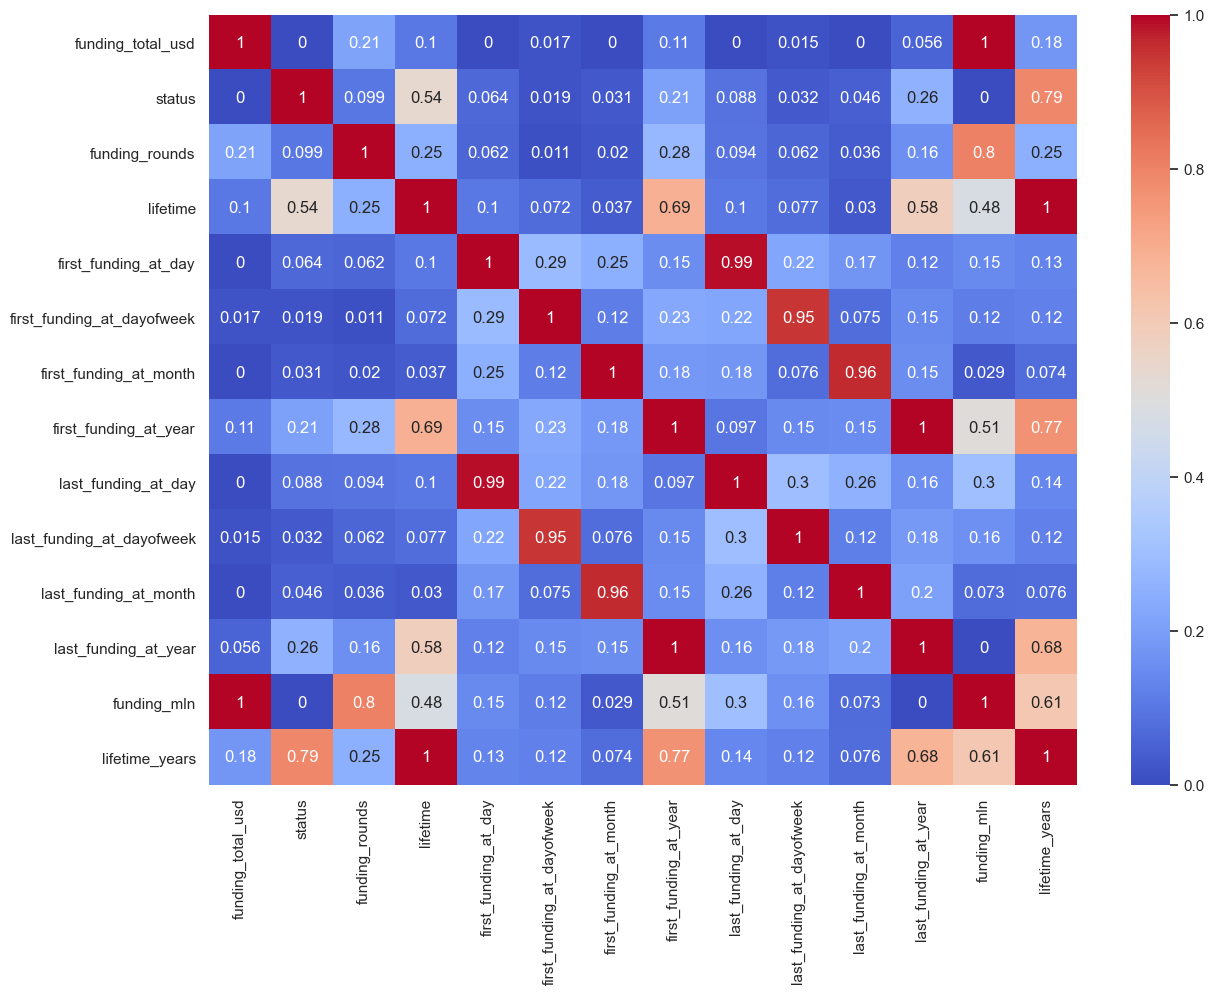

In [121]:
columns_to_drop = ['name', 'category_list', 'country_code', 'state_code', 'region', 'first_funding_at', 'last_funding_at', 'city']
startups_data_multi = startups_data.drop(columns=columns_to_drop)

plt.figure(figsize=(14, 10))
sns.heatmap(
    startups_data_multi.phik_matrix(
        interval_cols=['lifetime','funding_rounds','funding_total_usd']
    ), 
    annot=True, 
    cmap='coolwarm'
) ;

На диаграмме датасета ``startups_data`` видно, что целевой признак больше всех коррелирует с количеством лет жизни стратапа.

Диаграмма для ``startups_test``

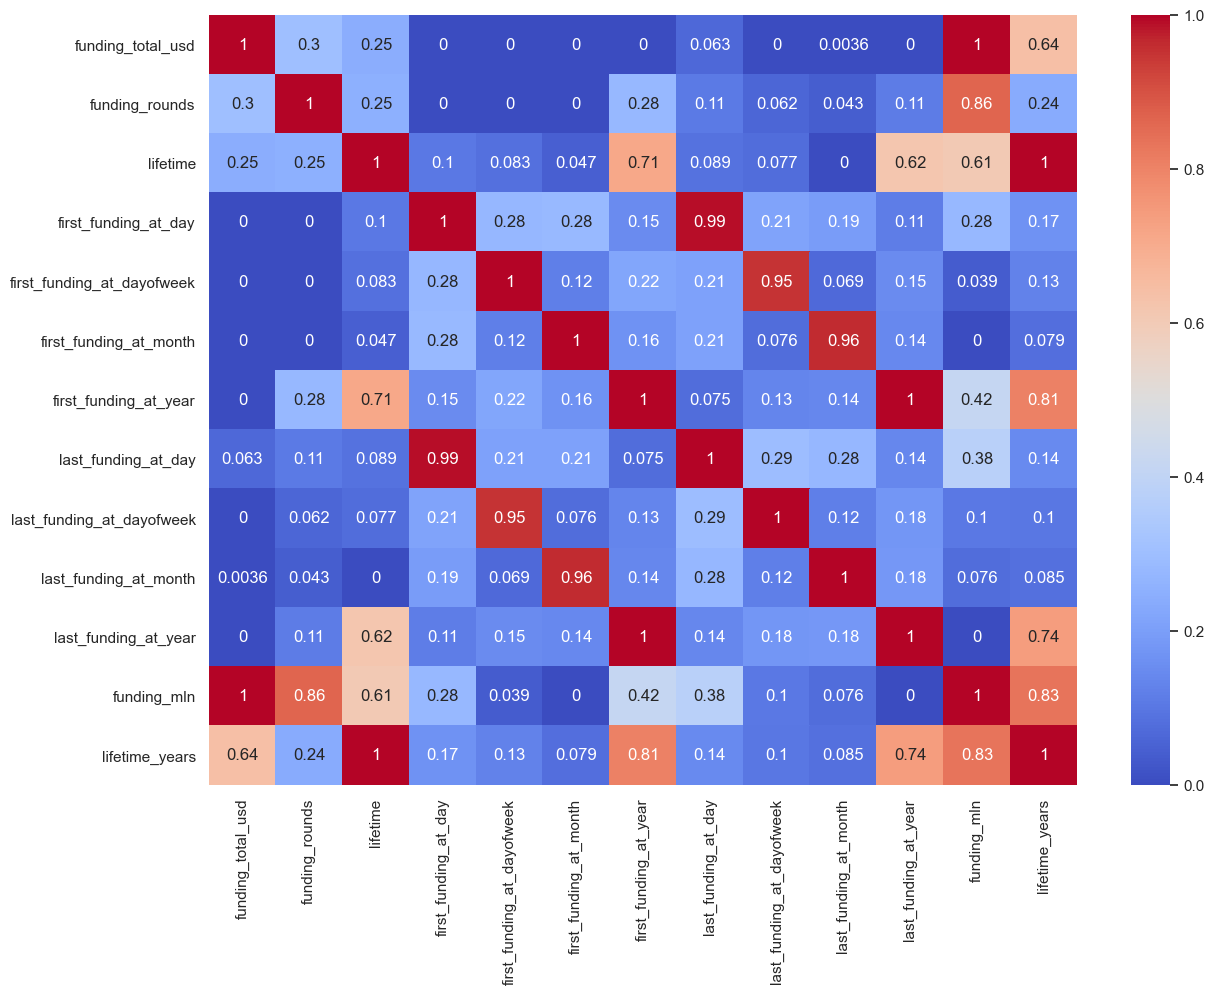

In [122]:
columns_to_drop = ['name', 'category_list', 'country_code', 'state_code', 'region', 'first_funding_at', 'last_funding_at', 'city']
startups_test_multi = startups_test.drop(columns=columns_to_drop)

plt.figure(figsize=(14, 10))
sns.heatmap(
    startups_test_multi.phik_matrix(
        interval_cols=['lifetime','funding_rounds','funding_total_usd']
    ), 
    annot=True, 
    cmap='coolwarm'
) ;

На обеих диаграммах видны пары признаков выше порога в 0.9:
- **funding_total_usd** и **funding_mln**;
- **lifetime** и **lifetime_years**;
- **last_funding_at_day** и **first_funding_at_day**;
- **last_funding_at_dayofweek** и **first_funding_at_dayofweek**;
- **last_funding_at_month** и **first_funding_at_month**;
- **last_funding_at_year** и **first_funding_at_year**.

Удалим эти признаки из датасетов.

In [123]:
multi_columns_to_drop = ['funding_total_usd','lifetime','first_funding_at_day',\
                         'first_funding_at_dayofweek','first_funding_at_month','first_funding_at_year']

startups_data_categorized = startups_data_categorized.drop(columns=multi_columns_to_drop)
startups_test_categorized = startups_test_categorized.drop(columns=multi_columns_to_drop)

startups_data = startups_data.drop(columns=multi_columns_to_drop)
startups_test = startups_test.drop(columns=multi_columns_to_drop)

# Отбор финального набора обучающих признаков

In [124]:
startups_data.columns.values

array(['name', 'category_list', 'status', 'country_code', 'state_code',
       'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'last_funding_at_day',
       'last_funding_at_dayofweek', 'last_funding_at_month',
       'last_funding_at_year', 'funding_mln', 'lifetime_years'],
      dtype=object)

Удаляем признки **name**, **category_list**, **state_code**, **region**, **first_funding_at**, **last_funding_at**

In [125]:
columns_to_drop_final = ['country_code', 'name', 'city', 'category_list', 'state_code', 'region', 'first_funding_at', 'last_funding_at']

In [126]:
#

In [127]:
# Попытка использовать все категории, потребяет очень много памяти
#startups_data = startups_data_categorized
#startups_test = startups_test_categorized

In [128]:
#

In [129]:
startups_data = startups_data.drop(columns=columns_to_drop_final)

In [130]:
startups_test = startups_test.drop(columns=columns_to_drop_final)

In [131]:
#startups_data.head(1)

In [132]:
#startups_test.head(1)

# Подготовка данных

In [133]:
X = startups_data.drop(['status'], axis = 1)
y = startups_data['status']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y # выравниваем соотношение
) 

In [134]:
# вывожу на экран размер получившихся данные после подготовки
print('Размер подготовленных выборок:')
display(pd.DataFrame(
    data={
        'Входные признаки(X)': [X_train.shape, X_val.shape],
        'Целевой признак(y)': [y_train.shape, y_val.shape]
    }, 
    index=['Тренировочные данные', 'Тестовые данные']
))


Размер подготовленных выборок:


,Входные признаки(X),Целевой признак(y)
Тренировочные данные,"(39387, 7)","(39387,)"
Тестовые данные,"(13129, 7)","(13129,)"


In [135]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39387 entries, 33502 to 13332
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   funding_rounds             39387 non-null  int64  
 1   last_funding_at_day        39387 non-null  int64  
 2   last_funding_at_dayofweek  39387 non-null  int64  
 3   last_funding_at_month      39387 non-null  int64  
 4   last_funding_at_year       39387 non-null  int64  
 5   funding_mln                39387 non-null  float64
 6   lifetime_years             39387 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 2.4 MB


# Выбор и обучение моделей

#### Поля для обработчиков

In [136]:
# зададим поля для обработчиков
#ohe_cols = ['country_code']
ohe_cols = []
num_cols = ['funding_mln','funding_rounds','lifetime_years', 'last_funding_at_day', 'last_funding_at_dayofweek', 'last_funding_at_month','last_funding_at_year']

#### Пайплайны обработчиков, препроцессор

In [137]:
# ohe - пайплайн (SimpleImputer, OneHotEncoder)
ohe_processor = Pipeline(    
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(
                drop='first', handle_unknown='error', sparse=True
            )
        )
    ]
)

In [138]:
# препроцессор - пайплайн обработки
data_preprocessor = ColumnTransformer(
    [        
        ('ohe', ohe_processor, ohe_cols),    
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

#### Готовый пайплайн

In [139]:
# готовая сброка - пайплайн
pipe_final = Pipeline(    
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Проверка пайпа на наличие ошибок

In [140]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  ['funding_mln',
                                                   'funding_rounds',
                                                   'lifetime_years',
                                                   'last_funding_at_day',
                                                   'last_funding_at_dayo

Пайп рабочий

#### Подготовка параметров

In [141]:
params = [    
    { # параметры для модели DecisionTreeClassifier()
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },    
    { # параметры для модели KNeighborsClassifier() 
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    { # параметры для модели LogisticRegression()
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,10), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

#### Поиск лучшей модели

In [142]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    params,
    cv=5,
    n_jobs=-1,
    scoring='f1',
    random_state = RANDOM_STATE
)

In [143]:
%%time
randomized_search.fit(X_train, y_train)

CPU times: total: 875 ms
Wall time: 16.7 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               []),
                                                                              ('num',
                                                                               Sta

In [144]:
# лучшая модель
model_best = randomized_search.best_estimator_

In [145]:
#print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучшая модель и её параметры:\n\n', model_best)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  []),
                                                 ('num', StandardScaler(),
                                                  ['funding_mln',
                                                   'funding_rounds',
                                                   'lifetime_years',
                                                   'last_funding_at_day',
                                        

In [146]:
y_val_pred = randomized_search.predict(X_val)

In [147]:
print(f'Метрика F1 на валидационной выборке: {f1_score(y_val, y_val_pred)}')

Метрика F1 на валидационной выборке: 0.9821361959630289


**Вывод:**
- метрика f1 для DecisionTreeClassifier(max_depth=3, max_features=3, random_state=42) модели 0.98

# Итоговая оценка качества предсказания лучшей модели

Используем DummyClassifier для сравнения с моделью, чтобы убедиться, что она действительно работает.

In [148]:
dummy_clf = DummyClassifier(random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

dummy_pred = dummy_clf.predict(X_val)
dummy_f1 = f1_score(y_val, dummy_pred)

print(f'Метрика F1 на тестовой выборке в DummyClassifier: {dummy_f1:.3f}')

Метрика F1 на тестовой выборке в DummyClassifier: 0.951


##### Лучшие модели

In [149]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(5)

,rank_test_score,param_models,mean_test_score,params
3,1,"DecisionTreeClassifier(max_depth=3, max_featur...",0.98,"{'preprocessor__num': StandardScaler(), 'model..."
6,2,KNeighborsClassifier(),0.98,"{'preprocessor__num': StandardScaler(), 'model..."
0,3,KNeighborsClassifier(),0.98,"{'preprocessor__num': StandardScaler(), 'model..."
2,4,KNeighborsClassifier(),0.98,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,5,KNeighborsClassifier(),0.97,"{'preprocessor__num': MinMaxScaler(), 'models_..."


##### Матрица ошибок

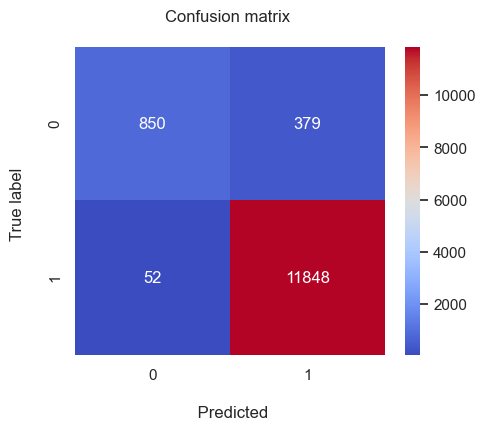

In [150]:
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm').set_title('Confusion matrix \n')
plt.ylabel('True label \n')
plt.xlabel('\n Predicted')
plt.show() ;

## Предсказание и выгрузка ``startups_test``

In [151]:
y_test = model_best.predict(startups_test) # предсказание на startup_test

df_result = pd.DataFrame( # датафрейм с предсказаниями для выгрузки результата
    data={
        'name': startups_test_source['name'],
        'status': ['operating' if x == 1 else 'closed' for x in y_test]
    }
)

In [152]:
# вывод результата
print('Сэмпл предсказаний')
df_result.sample(5)

Сэмпл предсказаний


,name,status
715,Organics Rx,operating
2654,Red Ambiental,closed
13118,Onfido,operating
3588,Active Voice Corporation,operating
5966,Treehouse,operating


In [153]:
print('Количество объектов каждого статуса в df_test')
display(pd.DataFrame(df_result['status'].value_counts()))

Количество объектов каждого статуса в df_test


,status
operating,12195
closed,930


In [154]:
# выгрузка результата в csv файл
df_result.to_csv('predict_result.csv', index=False)

In [155]:
# чек - создан ли файл с предсказаниями
try:
    predict_result = pd.read_csv('./predict_result.csv')
    display(predict_result.head(5))
    print("Файл с предсказаниями создан успешно")
except:
    print("Ошибка. Файл с предсказаниями не создан")

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


Файл с предсказаниями создан успешно


# Анализ важности признаков модели

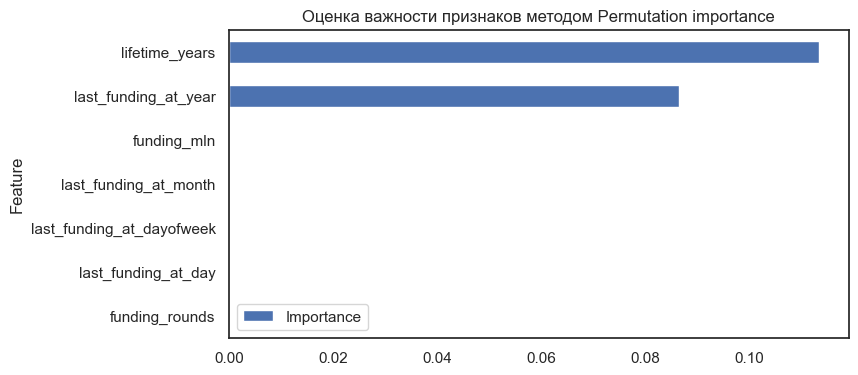

In [158]:
result = permutation_importance(model_best, startups_test, y_test, scoring='f1')

feature_importance = pd.DataFrame({'Feature': startups_test.columns, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 4))
plt.title("Оценка важности признаков методом Permutation importance")
plt.show()

Важные признаки для предсказания жизни стартапа - **lifetime** и **last_funding_at_year**

# Отчёт по исследованию

**Выводы:**
- на основе данных выбрана и протестирована модель машинного обучения ... для прогнозирования закрытия стартапов.
- модель продемонстрировала высокую эффективность - качество по метрике F1-мера - 0.98.
- анализ важности признаков выявил, что на предсказание успеха влияют время жизни и года первого/последнего финансирования
- модель и результаты исследования можно использовать для оценки рисков и принятия решений о финансировании стартапа или участия в нем иными способами

**Рекомендации:**  
- для актуализации модели можно рекомендовать добавить актуальные данные, начиная с 2016 года и по нынешнюю дату
- так же имеет смысл расширить список модельей машинного обучения помимо тех, что использованы при выборе текущей лучшей модели